# Введение

Заказчик - сервис подбора репетитороов Repetit.ru. Заказчик предоставил данные заявок от потенциальных учеников, данные всех репетиторов и данные репетиторов, подходящих под условия заявок. В данных несколько десятков миллионов строк. Вся информация о репетиторах и учениках обезличена. Задача осложнена тем, что каждая заявка в системе постоянно видоизменяется, создавая собственные дубли. Для заказчика важно, чтобы модель не пропускала потенциально хорошие заявки: нужен высокий precision положительного класса.

**Цель:** предсказать, будет ли оплачена заявка на обучение с репетитором.

**Предварительный план работы:**

1. Ознакомиться с данными, отсеять бесполезную информацию.
2. Проанализировать данные, найти полезные для создания признаков закономерности.
3. Объединить данные, агрегировать их при необходимости.
4. Создать целевой признак, синтезировать обучающие признаки.
5. Разделить данные на выборки, провести обучение моделей.
6. Выбрать лучшую модель, оценить ее.
7. Подвести итоги исследования.

**Обзор данных**

Заказчик предоставил три файла:
- **Данные заявок от потенциальных учеников.** Часть заявок была оплачена. Данные содержат множество дублей: заявка дублируется после каждого действия с ней ученика или сотрудника repetit.ru. Файл включает информацию об ученике, его целях и требованиях к репетитору и занятиям.
- **Данные всех репетиторов в системе.** Содержат подробную информацию о каждом репетиторе, зарегистрированном на сайте.
- **Репетиторы, подходящие под условия заявки.** Файл включает репетиторов, отфильтрованных алгоритмом под условия каждой заявки. к.

# Загрузка данных

## Импорты

In [1]:
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    confusion_matrix
)
from sklearn.preprocessing import LabelEncoder

In [2]:
# сохраним путь к файлам
PATH = Path("E:/repetit_project/")

# зафиксируем параметр random state
RS = 45

In [3]:
# отобразим все столбцы и строки в таблицах
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# отфильтруем предупреждения
warnings.filterwarnings('ignore')

# используем стиль графиков seaborn
sns.set_theme()

In [4]:
# напишем функцию проверки датасета
def check_data(df):
    display(
        df.info(),
        df.nunique(),
        df.describe(include='all'),
        df.head(),
        df.sample(5, random_state=RS)
    )
    print('Дубликатов строк:', df.duplicated().sum())

## Загрузка данных заявок

In [5]:
# загрузим данные заявок
orders = pd.read_feather(PATH/'orders.feather')

# проверим датасет
check_data(orders)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

None

id                         1190961
order_date                 1190749
subject_id                      30
purpose                     294447
lesson_price                   349
lesson_duration                  9
lesson_place                     4
home_metro_id                 2326
add_info                    609437
start_date                  705033
working_teacher_id           58534
status_id                       18
comments                     93505
prefered_teacher_id              3
amount_to_pay                 1415
planned_lesson_number            8
first_lesson_date              818
creator_id                  107753
pupil_category_new_id           19
lessons_per_week                11
minimal_price                  171
teacher_sex                      7
teacher_experience_from         43
teacher_experience_to           68
lesson_place_new                11
pupil_knowledgelvl               8
teacher_age_from                86
teacher_age_to                 109
chosen_teachers_only

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
count,1.191861e+06,1191861,1.181529e+06,1025351,1.191861e+06,1.191861e+06,31,6.424470e+05,1044688,705578,7.059880e+05,1.191861e+06,341468,4.000000e+00,1191861,1.191861e+06,166571,5.796980e+05,1.032470e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,5.825880e+05,1.191861e+06,1.042385e+06,1.351800e+04,747152,129665,1.191861e+06
unique,NaN,1190749,NaN,294447,NaN,NaN,4,NaN,609437,705033,NaN,NaN,93505,NaN,1415,NaN,818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1593,124285,NaN
top,NaN,2021-09-16 03:58:15.883,NaN,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,NaN,NaN,у ученика,NaN,Количество занятий в неделю: 1-2.\nВозраст реп...,2023-01-07 19:41:37.827,NaN,NaN,Тестовая группа : SplitTestB,NaN,0,NaN,2022-09-06 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2023-03-12 14:20:12.353,NaN
freq,NaN,4,NaN,11450,NaN,NaN,24,NaN,7234,2,NaN,NaN,72450,NaN,1038096,NaN,599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57788,37,NaN
mean,2.340488e+06,NaN,2.138735e+01,NaN,2.019466e+03,7.186754e+01,NaN,8.130288e+02,NaN,NaN,1.644861e+05,2.436352e+01,NaN,3.342593e+06,NaN,1.952076e+01,NaN,6.682231e+05,2.286848e+01,1.423346e+01,2.129868e+02,1.329890e+01,1.268675e+01,1.211135e+01,1.407590e+01,1.160722e+01,1.955505e+01,2.863540e+01,2.237090e-02,9.083526e-02,2.877031e+01,2.325827e+06,9.625180e+05,2.357963e+01,1.388366e+03,NaN,NaN,9.641678e-01
std,3.445563e+05,NaN,6.157333e+03,NaN,9.163341e+05,6.130494e+03,NaN,8.375082e+03,NaN,NaN,8.184790e+04,6.130578e+03,NaN,1.858466e+05,NaN,6.130586e+03,NaN,4.013024e+05,6.586820e+03,6.130595e+03,1.111145e+04,6.130597e+03,6.130598e+03,6.130605e+03,6.130596e+03,6.130600e+03,6.130600e+03,6.131385e+03,1.478866e-01,2.873748e-01,6.130570e+03,3.480297e+05,2.177188e+05,6.555417e+03,7.184427e+04,NaN,NaN,1.858717e-01
min,1.742636e+06,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,1.000000e+00,NaN,NaN,3.300000e+01,1.000000e+00,NaN,3.211265e+06,NaN,0.000000e+00,NaN,4.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e+01,-1.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+02,1.000000e+00,1.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00
25%,2.041441e+06,NaN,3.000000e+00,NaN,5.000000e+02,6.000000e+01,NaN,2.280000e+02,NaN,NaN,1.009130e+05,7.000000e+00,NaN,3.211265e+06,NaN,1.000000e+01,NaN,3.046100e+05,8.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,2.022765e+06,8.680830e+05,7.000000e+00,3.000000e+01,NaN,NaN,1.000000e+00
50%,2.341556e+06,NaN,8.000000e+00,NaN,1.000000e+03,6.000000e+01,NaN,6.440000e+02,NaN,NaN,1.695160e+05,1.600000e+01,NaN,3.276801e+06,NaN,1.000000e+01,NaN,7.806650e+05,1.000000e+01,3.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,2.318886e+06,9.896330e+05,1.000000e+01,3.000000e+01,NaN,NaN,1.000000e+00
75%,2.638720e+06,NaN,1.300000e+01,NaN,1.500000e+03,6.000000e+01,NaN,1.146000e+03,NaN,NaN,2.343302e+05,1.600000e+01,NaN,3.408129e+06,NaN,1.000000e+01,NaN,9.715650e+05,1.200000e+01,4.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,0.000000e+

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
136427,2724438,2023-08-23 20:24:24.160,2.0,Разделы: общий курс.\nКатегория ученика: школь...,900,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2023-08-23 23:27:42.070,87127.0,16,None,NaN,0,10,None,1162206.0,9.0,3,0,3,10,0,4,0,0,0,0,0,14,2724199.0,1115411,17.0,NaN,2520,None,1
28609,2322667,2022-11-16 00:04:05.417,8.0,Цели: улучшить успеваемость.\nКатегория ученик...,900,60,None,1658.0,Адрес ученика: Парк Гагарина.\nЖелаемое время ...,None,NaN,16,None,NaN,0,2,None,NaN,8.0,3,0,0,0,0,2,0,16,90,0,0,23,NaN,1033778,5.0,NaN,None,None,1
305171,2148417,2022-08-26 09:30:18.853,18.0,Разделы: все предметы.\nКатегория ученика: шко...,350,60,None,838.0,Район: Фестивальный район.\nМесто проведения з...,None,NaN,16,None,NaN,0,2,None,NaN,4.0,5,0,3,0,0,1,0,0,0,1,0,8,NaN,817055,18.0,NaN,None,None,1
72197,1815495,2021-10-10 19:06:23.783,12.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,500,60,None,NaN,"Пожелания: 3 курс, медицинского ВУЗа, подготов...",None,NaN,16,None,NaN,0,10,None,59899.0,14.0,3,0,2,0,0,0,0,0,0,0,0,3,1814883.0,856577,3.0,NaN,None,None,1
55117,2533734,2023-03-17 20:12:16.807,8.0,Разделы: алгебра.\nКатегория ученика: школьник...,900,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2023-03-19 12:52:01.270,233148.0,16,None,NaN,0,10,None,NaN,8.0,3,700,2,5,0,4,0,25,90,0,0,23,NaN,1116770,13.0,NaN,2520,None,1


Дубликатов строк: 900


В данных заявок множество признаков, в том числе явно бесполезных и признаков из будущего. Также есть пропуски в значительном количестве столбцов. В данных 900 полных дубликатов строк. У дат тип данных строковый.

## Загрузка данных репетиторов

In [6]:
# загрузим данные всех репетиторов
teachers_info = pd.read_feather(PATH/'teachers_info.feather')

# проверим датасет
check_data(teachers_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

None

id                            307972
date_update                   307079
reg_date                      307729
birth_date                     22247
teaching_start_date              776
user_id                       307972
is_email_confirmed                 2
is_home_lessons                    2
is_external_lessons                2
external_comments              26082
lesson_duration                  101
lesson_cost                      324
status_id                          6
status_relevant_date            1575
status_school_id                3595
status_college_id                851
status_display                     2
russian_level_id                   6
home_country_id                  147
information                   121897
is_confirmed                       2
external_comments.1            26082
lesson_duration.1                101
lesson_cost.1                    324
status_id.1                        6
status_relevant_date.1          1575
status_school_id.1              3595
s

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
count,307972.000000,307972,307972,307972,307972,3.079720e+05,307972.000000,307972.000000,307972.000000,90978,307972.000000,3.079720e+05,307972.000000,46379,14873.0,6543.0,307972.000000,307972.000000,307972.000000,132972,307972.000000,90978,307972.000000,3.079720e+05,307972.000000,46379,14873.0,6543.0,307972.000000,307972.000000,307972.000000,132972,307972.000000,90978,307972.000000,3.079720e+05,307972.000000,46379,14873.0,6543.0,307972.000000,307972.000000,307972.000000,185484,132972,307972.000000,307972.000000,307972.000000,307972.000000,44940,307972,235837,11208.000000,307972.000000,307972.0,307972.000000,29928,307972.000000,307972.000000,307972.000000,6043,307972.000000,307972.000000,307972.000000,307972.0,307972.0,1323.0,307972.000000,307972.000000,307972.0,307972.000000,78418.0,47734,307972.000000,307972.0,307972.000000,307972,307972.000000,24902.0,1705
unique,NaN,307079,307729,22247,776,NaN,NaN,NaN,NaN,26082,NaN,NaN,NaN,1575,NaN,NaN,NaN,NaN,NaN,121897,NaN,26082,NaN,NaN,NaN,1575,NaN,NaN,NaN,NaN,NaN,121897,NaN,26082,NaN,NaN,NaN,1575,NaN,NaN,NaN,NaN,NaN,179958,121897,NaN,NaN,NaN,NaN,36902,222686,235805,NaN,NaN,NaN,NaN,4571,NaN,NaN,NaN,2602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6062,NaN,NaN,NaN,222907,NaN,NaN,1705
top,NaN,2023-01-18 20:08:30.657,2007-12-24 19:26:46.000,1989-01-01 00:00:00.000,2017-09-01 00:00:00.000,NaN,NaN,NaN,NaN,Ближайший район: Не указано.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,NaN,Ближайший район: Не указано.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,NaN,Ближайший район: Не указано.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,/photo/no_photo.png,РЕГИСТРАЦИЯ НЕ БЫЛА ЗАКОНЧЕНА,NaN,NaN,NaN,NaN,год окончания вуза,2014-08-12 00:00:00.000,2017-01-18 09:40:42.000,NaN,NaN,NaN,NaN,2023-09-01 00:00:00.000,NaN,NaN,NaN,Возможны занятия по Skype.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ya_mow_own_sn_hv,NaN,NaN,NaN,2017-01-01 00:00:00.000,NaN,NaN,2021-10-23 13:04:52.410
freq,NaN,3,134,111,19269,NaN,NaN,NaN,NaN,3201,NaN,NaN,NaN,3105,NaN,NaN,NaN,NaN,NaN,6916,NaN,3201,NaN,NaN,NaN,3105,NaN,NaN,NaN,NaN,NaN,6916,NaN,3201,NaN,NaN,NaN,3105,NaN,NaN,NaN,NaN,NaN,5527,6916,NaN,NaN,NaN,NaN,106,85235,2,NaN,NaN,NaN,NaN,1200,NaN,NaN,NaN,339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6086,NaN,NaN,NaN,84976,NaN,NaN,1
mean,157246.177036,NaN,NaN,NaN,NaN,4.861595e+05,0.012732,0.421749,0.599145,NaN,61.502978,5.325806e+02,4.176467,NaN,inf,inf,0.543734,4.239327,7.420168,NaN,0.890305,NaN,61.502978,5.325806e+02,4.176467,NaN,inf,inf,0.543734,4.239327,7.420168,NaN,0.890305,NaN,61.502978,5.325806e+02,4.176467,NaN,inf,inf,0.543734,4.239327,7.420168,NaN,NaN,0.890305,0.658735,10.222364,-222.160797,NaN,NaN,Na

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.0,0,4.679688,1,NaN,1,500,1,NaN,0,1,0,1138.0,237.5,NaN,1,0,492.0,1,NaN,NaN,4.500000,1138.0,6,2022-05-16 18:44:59.993,0,3702.0,2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.0,0,0.000000,1,NaN,3,0,0,NaN,0,1,1,25.0,0.0,NaN,1,1,0.0,1,NaN,NaN,4.300781,25.0,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.0,0,6.000000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.0,0.0,NaN,1,1,2182.0,3,0.0,NaN,4.300781,300.0,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.0,0,11.289062,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.0,0.0,NaN,1,1,2084.0,1,0.0,NaN,5.000000,135.0,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
145586,148981,2023-01-17 22:33:18.513,2018-09-09 01:51:13.197,1996-07-10 00:00:00.000,2014-09-01 00:00:00.000,388445,0,0,1,Ближайший район: м. Юго-Западная.,60,1000,5,NaN,NaN,NaN,1,5,7,[p]Имею высшее лингвистическое образование: ба...,1,Ближайший район: м. Юго-Западная.,60,1000,5,NaN,NaN,NaN,1,5,7,[p]Имею высшее лингвистическое образование: ба...,1,Ближайший район: м. Юго-Западная.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/148981/photo/photo_small.webp,[p]Имею высшее лингвистическое образование: ба...,1,1,17,7,NaN,2018-09-09 01:51:13.197,2022-10-05 12:14:58.287,NaN,0,0.0,1,NaN,2,0,1,NaN,1,1,1,355.0,0.0,NaN,1,1,1876.0,3,NaN,ya_mow_own_sn_hv,5.000000,355.0,1,2018-09-09 01:51:13.197,0,NaN,NaN
104725,107193,2023-01-19 19:34:20.187,2016-07-18 11:34:05.000,1973-10-28 00:00:00.000,2000-09-01 00:00:00.000,151905,1,1,1,NaN,45,250,5,NaN,NaN,NaN,0,5,7,NaN,1,NaN,45,250,5,NaN,NaN,NaN,0,5,7,NaN,1,NaN,45,250,5,NaN,NaN,NaN,0,5,7,NaN,NaN,1,1,2,-1,NaN,2014-08-12 00:00:00.000,2018-06-15 22:32:38.897,NaN,1,0.0,42,NaN,2,0,0,NaN,0,0,0,0.0,0.0,NaN,1,1,797.0,0,0.0,NaN,4.300781,0.0,0,2017-01-01 00:00:00.000,0,NaN,NaN
264707,269327,2023-11-04 13:59:32.903,2022-08-25 13:34:27.773,1983-02-06 00:00:00.000,2010-09-01 00:00:00.000,1004209,0,1,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Специалист с дипломом (преподаватель иностр...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Специалист с дипломом (преподаватель иностр...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/269327/photo/photo_small.jpg,[p]Специалист с дипломом (преподаватель иностр...,1,1,15,5,NaN,2022-08-25 13:34:27.773,2022-10-18 18:01:38.950,NaN,0,0.0,1,NaN,2,0,1,NaN,1,1,1,1412.0,562.5,NaN,0,1,431.5,3,NaN,NaN,4.300781,1412.0,0,2022-11-30 22:10:20.837,1,NaN,NaN
179429,183831,2023-01-18 18:09:48.393,2019-10-24 21:21:32.080,1991-05-14 00:00:00.000,2012-09-01 00:00:00.000,579200,0,1,1,NaN,60,0,5,NaN,NaN,NaN,1,5,7,[p]Система образования сейчас настолько многог...,1,NaN,60,0,5,NaN,NaN,NaN,1,5,7,[p]Система образования сейчас настолько многог...,1,NaN,60,0,5,NaN,NaN,NaN,1,5,7,/teachers/183831/photo/photo_small.webp,[p]Система образования сейчас настолько многог...,1,1,16,6,NaN,2019-10-24 21:21:32.080,2021-08-26 19:32:32.007,NaN,0,0.0,12,NaN,2,0,1,NaN,0,1,1,180.0,0.0,NaN,0,0,1470.0,1,NaN,NaN,4.800781,180.0,6,2020-03-15 18:12:15.743,1,NaN,NaN
44369,45798,2023-01-19 15:17:37.540,2012-11-14 13:04:33.000,1975-09-23 00:00:00.000,1996-09-01 00:00:00.000,46983,0,1,0,NaN,90,2500,5,NaN,NaN,NaN,1,5,7,[p]Кандидат физико-математических наук. Опыт у...,1,NaN,90,2500,5,NaN,NaN,NaN,1,5,7,[p]Кандидат физико-математических наук. Опыт у...,1,NaN,90,2500,5,NaN,NaN,NaN,1,5,7,NaN,[p]Кандидат физико-математических наук. Опыт у...,1,0,2,-1,NaN,2016-09-22 09:54:16.000,2017-10-04 23:19:54.000,NaN,0,-2.0,1,NaN,2,0,0,NaN,

Дубликатов строк: 0


Данные репетиторов содержат множество малополезных признаков. Названия некоторых столбцов дублированы. В данных большое количество пропусков. У дат тип данных category.

## Загрузка данных подходящих репетиторов

In [7]:
# загрузим данные репетиторов, подходящих по фильтру
suitable_teachers = pd.read_feather(PATH/'suitable_teachers.feather')

# проверим датасет
check_data(suitable_teachers)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


None

teacher_id            145944
order_id              842019
contact_result         10866
enable_auto_assign         2
enable_assign              2
dtype: int64

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
count,2.027119e+07,2.027119e+07,7446824,2.027119e+07,2.027119e+07
unique,NaN,NaN,10866,NaN,NaN
top,NaN,NaN,.,NaN,NaN
freq,NaN,NaN,1846839,NaN,NaN
mean,1.578108e+05,2.500198e+06,NaN,1.291083e-01,2.754817e-02
std,8.024676e+04,3.338940e+05,NaN,3.353198e-01,1.636743e-01
min,3.300000e+01,1.742638e+06,NaN,0.000000e+00,0.000000e+00
25%,9.542000e+04,2.265722e+06,NaN,0.000000e+00,0.000000e+00
50%,1.595950e+05,2.571756e+06,NaN,0.000000e+00,0.000000e+00
75%,2.241730e+05,2.779002e+06,NaN,0.000000e+00,0.000000e+00


,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1


,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
17723502,263707,2866893,NaN,0,0
438654,108893,1795387,NaN,1,0
10577375,59725,2587515,NaN,0,0
8893193,113922,2528180,NaN,0,0
19069087,133301,2910202,NaN,0,0


Дубликатов строк: 49


Пропуски только в столбце contact_result, также есть 49 полных дубликатов строк. 

**Вывод:**

Мы успешно загрузили данные и провели их легкую разведку. В данных есть множество малополезных признаков и признаков из будущего. Некоторые столбцы возможно были дублированы при выгрузке из БД. В колонках множественные пропуски, есть небольшое количество полных дубликатов строк.

Далее отсеем бесполезные признаки и ненужные строки:

# Отсев неактуальных признаков и строк

## Отсев данных подходящих репетиторов

In [8]:
# удалим столбец из будущего
suitable_teachers.drop(
    ['contact_result'],
    axis=1,
    inplace=True
)
# удалим полные дубликаты строк
suitable_teachers.drop_duplicates(inplace=True)

# проверим результат
print(
    suitable_teachers.info(),
    suitable_teachers.duplicated().sum()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20271045 entries, 0 to 20271185
Data columns (total 4 columns):
 #   Column              Dtype
---  ------              -----
 0   teacher_id          int32
 1   order_id            int32
 2   enable_auto_assign  int8 
 3   enable_assign       int8 
dtypes: int32(2), int8(2)
memory usage: 348.0 MB
None 0


## Отсев данных репетиторов

Объединим таблицу teachers_info с уникальными teacher_id из suitable_teachers. Так мы сразу отсеем репетиторов, которых нет в suitable_teachers и сможем проверить распределение данных без них. Пока не будем объединять teachers_info и suitable_teachers целиком чтобы не увеличивать количество строк в анализируемой таблице.

In [9]:
# функция актуализирует teacher_id в teachers_info, возвращая актуализированные данные
def get_actual_teacher_id(teachers_info, suitable_teachers):
    teachers_info1 = teachers_info.copy()
    suitable_teachers1 = suitable_teachers.copy()
    # переименуем столбец для корректного объединения
    teachers_info1.rename(columns={'id': 'teacher_id'}, inplace=True)
    # оставим только актуальные teacher_id
    teachers_info_actual = teachers_info1.merge(
        pd.Series(suitable_teachers1['teacher_id'].unique(), name='teacher_id'), 
        on='teacher_id'
    )
    return teachers_info_actual
    
teachers_info_actual = get_actual_teacher_id(teachers_info, suitable_teachers)

# проверим результат
check_data(teachers_info_actual)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145942 entries, 0 to 145941
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   teacher_id                  145942 non-null  int32   
 1   date_update                 145942 non-null  category
 2   reg_date                    145942 non-null  category
 3   birth_date                  145942 non-null  category
 4   teaching_start_date         145942 non-null  category
 5   user_id                     145942 non-null  int32   
 6   is_email_confirmed          145942 non-null  int8    
 7   is_home_lessons             145942 non-null  int8    
 8   is_external_lessons         145942 non-null  int8    
 9   external_comments           43695 non-null   category
 10  lesson_duration             145942 non-null  int16   
 11  lesson_cost                 145942 non-null  int32   
 12  status_id                   145942 non-null  int8    
 13 

None

teacher_id                    145942
date_update                   145854
reg_date                      145867
birth_date                     20112
teaching_start_date              243
user_id                       145942
is_email_confirmed                 2
is_home_lessons                    2
is_external_lessons                2
external_comments               7601
lesson_duration                   32
lesson_cost                      228
status_id                          6
status_relevant_date            1202
status_school_id                3202
status_college_id                764
status_display                     2
russian_level_id                   6
home_country_id                  140
information                    78185
is_confirmed                       2
external_comments.1             7601
lesson_duration.1                 32
lesson_cost.1                    228
status_id.1                        6
status_relevant_date.1          1202
status_school_id.1              3202
s

,teacher_id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
count,145942.000000,145942,145942,145942,145942,1.459420e+05,145942.000000,145942.000000,145942.000000,43695,145942.000000,145942.000000,145942.000000,27019,9952.0,4710.0,145942.000000,145942.000000,145942.000000,79732,145942.000000,43695,145942.000000,145942.000000,145942.000000,27019,9952.0,4710.0,145942.000000,145942.000000,145942.000000,79732,145942.000000,43695,145942.000000,145942.000000,145942.000000,27019,9952.0,4710.0,145942.000000,145942.000000,145942.000000,120884,79732,145942.000000,145942.000000,145942.000000,145942.000000,9277,145942,129650,3094.000000,145942.000000,145942.00,145942.000000,23810,145942.000000,145942.000000,145942.000000,957,145942.000000,145942.000000,145942.000000,145942.0,145942.0,1031.0,145942.000000,145942.000000,145942.0,145942.000000,46887.000000,28598,145942.000000,145942.0,145942.000000,145942,145942.000000,17618.0,1620
unique,NaN,145854,145867,20112,243,NaN,NaN,NaN,NaN,7601,NaN,NaN,NaN,1202,NaN,NaN,NaN,NaN,NaN,78185,NaN,7601,NaN,NaN,NaN,1202,NaN,NaN,NaN,NaN,NaN,78185,NaN,7601,NaN,NaN,NaN,1202,NaN,NaN,NaN,NaN,NaN,119350,78185,NaN,NaN,NaN,NaN,9213,126759,129636,NaN,NaN,NaN,NaN,3220,NaN,NaN,NaN,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4293,NaN,NaN,NaN,127059,NaN,NaN,1620
top,NaN,2023-01-19 01:31:01.640,2007-12-24 19:26:46.000,1998-08-07 00:00:00.000,2017-09-01 00:00:00.000,NaN,NaN,NaN,NaN,Ближайший район: Ленинский район.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,[p]Опыт работы в школе.[/p],NaN,Ближайший район: Ленинский район.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,[p]Опыт работы в школе.[/p],NaN,Ближайший район: Ленинский район.,NaN,NaN,NaN,2024-06-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,/photo/no_photo.png,[p]Опыт работы в школе.[/p],NaN,NaN,NaN,NaN,\n,2014-08-12 00:00:00.000,2022-09-02 13:11:15.170,NaN,NaN,NaN,NaN,2023-09-01 00:00:00.000,NaN,NaN,NaN,\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ya_mow_own_sn_hv,NaN,NaN,NaN,2017-01-01 00:00:00.000,NaN,NaN,2021-10-23 13:04:52.410
freq,NaN,2,60,44,11181,NaN,NaN,NaN,NaN,882,NaN,NaN,NaN,2474,NaN,NaN,NaN,NaN,NaN,67,NaN,882,NaN,NaN,NaN,2474,NaN,NaN,NaN,NaN,NaN,67,NaN,882,NaN,NaN,NaN,2474,NaN,NaN,NaN,NaN,NaN,1535,67,NaN,NaN,NaN,NaN,20,19164,2,NaN,NaN,NaN,NaN,1185,NaN,NaN,NaN,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,NaN,NaN,NaN,18852,NaN,NaN,1
mean,167654.156973,NaN,NaN,NaN,NaN,5.198282e+05,0.013869,0.536734,0.682833,NaN,60.148696,666.785586,4.102568,NaN,inf,inf,0.670047,4.853675,7.651019,NaN,0.999486,NaN,60.148696,666.785586,4.102568,NaN,inf,inf,0.670047,4.853675,7.651019,NaN,0.999486,NaN,60.148696,666.785586,4.102568,NaN,inf,inf,0.670047,4.853675,7.651019,NaN,NaN,0.999486,0.911931,14.399672,-393.887538,NaN,NaN,NaN,0.939453,0.008127,NaN,8.841026,NaN,1.756931,0.00

,teacher_id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.0,0,4.679688,1,NaN,1,500,1,NaN,0,1,0,1138.0,237.5,NaN,1,0,492.0,1,NaN,NaN,4.500000,1138.0,6,2022-05-16 18:44:59.993,0,3702.0,2023-11-06 14:20:15.173
1,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.0,0,6.000000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.0,0.0,NaN,1,1,2182.0,3,0.0,NaN,4.300781,300.0,0,2017-01-01 00:00:00.000,0,NaN,NaN
2,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.0,0,11.289062,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.0,0.0,NaN,1,1,2084.0,1,0.0,NaN,5.000000,135.0,2,2020-04-01 01:07:44.157,1,NaN,NaN
3,86,2023-10-31 15:35:01.340,2007-12-24 19:26:46.000,1980-06-10 00:00:00.000,2006-09-01 00:00:00.000,105,0,1,1,NaN,60,1000,5,NaN,NaN,NaN,1,5,7,[p]Кандидат биологических наук. Окончила школу...,1,NaN,60,1000,5,NaN,NaN,NaN,1,5,7,[p]Кандидат биологических наук. Окончила школу...,1,NaN,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/86/photo/photo_small.webp,[p]Кандидат биологических наук. Окончила школу...,1,1,16,6,NaN,2015-08-20 11:01:13.000,2022-09-05 11:02:29.883,0.0,0,5.105469,69,2023-12-01 00:00:00.000,2,0,0,NaN,1,1,1,561.0,305.0,NaN,1,1,3624.0,3,0.0,NaN,5.000000,561.0,8,2021-07-31 23:18:05.217,1,NaN,NaN
4,87,2023-10-26 21:06:50.413,2007-12-24 19:26:46.000,1952-03-18 00:00:00.000,1996-09-01 00:00:00.000,106,0,1,0,NaN,60,1000,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к&nbsp;ЕГЭ по биологии.&nbsp;Ученик...,1,NaN,60,1000,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к&nbsp;ЕГЭ по биологии.&nbsp;Ученик...,1,NaN,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/87/pho

,teacher_id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
113902,242253,2023-01-19 10:46:56.667,2021-09-12 22:25:41.203,2001-08-24 00:00:00.000,2019-09-01 00:00:00.000,846126,0,0,1,NaN,45,0,5,NaN,NaN,NaN,0,5,7,NaN,1,NaN,45,0,5,NaN,NaN,NaN,0,5,7,NaN,1,NaN,45,0,5,NaN,NaN,NaN,0,5,7,/teachers/242253/photo/photo_small.webp,NaN,1,1,15,5,NaN,2021-09-12 22:25:41.203,2021-09-22 17:07:35.397,NaN,0,0.0,52,NaN,2,0,1,NaN,1,1,1,125.0,0.0,NaN,0,1,774.0,0,NaN,NaN,4.300781,125.0,0,2021-09-12 22:25:41.203,1,NaN,NaN
75375,175089,2023-01-18 02:07:11.357,2019-08-29 11:29:20.067,1996-11-25 00:00:00.000,2014-09-01 00:00:00.000,532072,0,0,1,Ближайший район: г. Зеленоград.,60,1000,2,2024-07-31 00:00:00.000,NaN,NaN,1,5,7,"[p]Ответственна, после 2-3 занятий улучшение о...",1,Ближайший район: г. Зеленоград.,60,1000,2,2024-07-31 00:00:00.000,NaN,NaN,1,5,7,"[p]Ответственна, после 2-3 занятий улучшение о...",1,Ближайший район: г. Зеленоград.,60,1000,2,2024-07-31 00:00:00.000,NaN,NaN,1,5,7,/teachers/175089/photo/photo_small.webp,"[p]Ответственна, после 2-3 занятий улучшение о...",1,1,16,6,NaN,2019-08-29 11:29:20.067,2021-06-11 10:14:50.177,NaN,0,0.0,1,2022-03-01 00:00:00.000,2,0,1,NaN,1,1,1,155.0,0.0,NaN,0,1,1447.0,1,NaN,ya_mow_own_sn_hv,5.000000,155.0,1,2019-08-29 11:29:20.067,1,NaN,NaN
145013,309363,2023-11-02 14:49:35.447,2023-10-07 13:13:25.513,2002-03-25 00:00:00.000,2020-09-01 00:00:00.000,1305427,0,1,1,NaN,60,1500,1,2024-06-01 00:00:00.000,NaN,NaN,0,5,7,NaN,1,NaN,60,1500,1,2024-06-01 00:00:00.000,NaN,NaN,0,5,7,NaN,1,NaN,60,1500,1,2024-06-01 00:00:00.000,NaN,NaN,0,5,7,/teachers/309363/photo/photo_small.jpg,NaN,1,1,15,5,NaN,2023-10-07 13:13:25.513,NaN,NaN,0,0.0,1,NaN,1,0,1,NaN,1,1,1,320.0,0.0,NaN,0,1,21.0,3,NaN,NaN,4.300781,320.0,0,2023-10-07 13:13:25.513,1,NaN,NaN
140982,299292,2023-08-11 06:31:46.267,2023-07-21 02:06:27.157,1987-11-19 00:00:00.000,2010-09-01 00:00:00.000,1228113,0,1,0,NaN,60,600,5,NaN,NaN,NaN,0,5,7,NaN,1,NaN,60,600,5,NaN,NaN,NaN,0,5,7,NaN,1,NaN,60,600,5,NaN,NaN,NaN,0,5,7,/teachers/299292/photo/photo_small.jpg,NaN,1,1,15,5,NaN,2023-07-21 02:06:27.157,NaN,NaN,0,0.0,33,NaN,2,0,1,NaN,0,1,1,200.0,0.0,NaN,0,1,104.0,0,NaN,NaN,4.300781,200.0,0,2023-07-21 02:06:27.157,1,NaN,NaN
21353,68877,2023-11-07 14:28:43.157,2014-08-17 16:39:18.000,1996-12-25 00:00:00.000,2015-09-01 00:00:00.000,70120,0,1,1,Ближайший район: м. Тропарёво.,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Профессиональный преподаватель-наставник по...,1,Ближайший район: м. Тропарёво.,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Профессиональный преподаватель-наставник по...,1,Ближайший район: м. Тропарёво.,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/68877/photo/photo_small.jpg,[p]Профессиональный преподаватель-наставник по...,1,1,17,7,\r\nКамалаева Е.А. 19.09.2019 11:54 - Заявка №...,2014-12-03 19:36:49.000,2022-10-15 16:53:29.847,N

Дубликатов строк: 0


In [10]:
# из данных о репетиторах исключим явно бесполезные признаки
teachers_info_actual.drop(
    [
        'date_update',
        'user_id',
        'external_comments',
        'status_id',
        'status_id.1',
        'status_id.2',
        'status_relevant_date',
        'status_school_id',
        'status_college_id',
        'information',
        'external_comments.1',
        'external_comments.2',
        'status_relevant_date.1',
        'status_school_id.1',
        'status_college_id.1',
        'information.1',
        'information.2', 
        'status_relevant_date.2',
        'status_school_id.2',
        'status_college_id.2',	
        'photo_path',
        'comments',
        'rules_confirmed_date',
        'is_pupils_needed',
        'area_id',
        'pupil_needed_date',
        'remote_comments',
        'passport_id',
        'is_individual',
        'partner_id',
        'relevance_date',
        'is_display_at_partners',
        'status_institution_id',
        'free_time_relevance_date',
        'russian_level_id',
        'russian_level_id.1',
        'russian_level_id.2',
        'home_country_id',
        'home_country_id.1',
        'home_country_id.2',
        'verification_status_id',
        'rating_id',
        'last_visited'
    ],
    axis=1,
    inplace=True
)

# проверим результат
teachers_info_actual.sample(5, random_state=RS)

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,lesson_duration.1,lesson_cost.1,status_display.1,is_confirmed.1,lesson_duration.2,lesson_cost.2,status_display.2,is_confirmed.2,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num
113902,242253,2021-09-12 22:25:41.203,2001-08-24 00:00:00.000,2019-09-01 00:00:00.000,0,0,1,45,0,0,1,45,0,0,1,45,0,0,1,1,5,0,0.0,2,0,1,1,1,1,125.0,0.0,0,1,774.0,4.300781,125.0,0
75375,175089,2019-08-29 11:29:20.067,1996-11-25 00:00:00.000,2014-09-01 00:00:00.000,0,0,1,60,1000,1,1,60,1000,1,1,60,1000,1,1,1,6,0,0.0,2,0,1,1,1,1,155.0,0.0,0,1,1447.0,5.000000,155.0,1
145013,309363,2023-10-07 13:13:25.513,2002-03-25 00:00:00.000,2020-09-01 00:00:00.000,0,1,1,60,1500,0,1,60,1500,0,1,60,1500,0,1,1,5,0,0.0,1,0,1,1,1,1,320.0,0.0,0,1,21.0,4.300781,320.0,0
140982,299292,2023-07-21 02:06:27.157,1987-11-19 00:00:00.000,2010-09-01 00:00:00.000,0,1,0,60,600,0,1,60,600,0,1,60,600,0,1,1,5,0,0.0,2,0,1,0,1,1,200.0,0.0,0,1,104.0,4.300781,200.0,0
21353,68877,2014-08-17 16:39:18.000,1996-12-25 00:00:00.000,2015-09-01 00:00:00.000,0,1,1,60,1500,1,1,60,1500,1,1,60,1500,1,1,1,7,0,0.0,2,0,1,0,1,1,1914.0,1222.0,1,1,3348.0,5.000000,1914.0,16


Комментарии по исключенным признакам:
- date_update - бесполезно
- user_id - id репетитора как пользователя сайта
- photo_path - путь к фотографии репетитора
- rules_confirmed_date - предположительно, дата согласия репетирора с правилами сервиса
- area_id - город репетирора, не получится агрегировать
- status_id, status_id.1, status_id.2 - статус репетитора, не получится агрегировать
- relevance_date - бесполезно
- is_display_at_partners - бесполезно
- russian_level_id, russian_level_id.1, russian_level_id.2 - не получится агрегировать
- home_country_id, home_country_id.1, home_country_id.2 - не получится агрегировать
- verification_status_id - не получится агрегировать
- rating_id - бесполезно
- last_visited - в обучение могут попасть данные из будущего, поскольку данные о репетиторах свежие, а заявки в обучающем наборе за несколько лет. Это не утечка, но будет не совсем корректно. Например, заявка может быть за 2021 год, а подходящий репетитор заходил на сайт в 2023 году.
  
Для заявок не получится агрегировать текстовые признаки:
- external_comments
- information
- external_comments.1
- information.1
- external_comments.2
- information.2
- comments
- remote_comments

Преимущественно пропуски:
- status_relevant_date
- status_school_id,
- status_college_id,
- status_relevant_date.1
- status_school_id.1,
- status_college_id.1
- is_pupils_needed
- pupil_needed_date
- passport_id
- is_individual
- partner_id
- status_institution_id
- free_time_relevance_date                      


In [11]:
# проверим, одинаковы ли столбцы с дублированными названиями
for name in [
    'is_confirmed',
    'status_display',
    'lesson_cost',
    'lesson_duration'
]:          
    print(
        f'Отличающихся значений в столбцах {name}: ', 
        (teachers_info_actual[f'{name}'] != teachers_info_actual[f'{name}.1']).sum() \
        + (teachers_info_actual[f'{name}'] != teachers_info_actual[f'{name}.2']).sum()
    )

Отличающихся значений в столбцах is_confirmed:  0
Отличающихся значений в столбцах status_display:  0
Отличающихся значений в столбцах lesson_cost:  0
Отличающихся значений в столбцах lesson_duration:  0


Столбцы - полные дубликаты. Удалим дубли:

In [12]:
teachers_info_actual.drop(
    [
        'is_confirmed.1',
        'status_display.1',
        'lesson_cost.1',
        'lesson_duration.1',
        'is_confirmed.2',
        'status_display.2',
        'lesson_cost.2',
        'lesson_duration.2'
    ],
    axis=1,
    inplace=True
)

# проверим результат
teachers_info_actual.columns

Index(['teacher_id', 'reg_date', 'birth_date', 'teaching_start_date',
       'is_email_confirmed', 'is_home_lessons', 'is_external_lessons',
       'lesson_duration', 'lesson_cost', 'status_display', 'is_confirmed',
       'is_display', 'rating', 'is_cell_phone_confirmed', 'effective_rating',
       'sex', 'amount_to_pay', 'is_remote_lessons', 'show_on_map',
       'send_mailing', 'send_suitable_orders', 'rating_for_users',
       'rating_for_admin', 'is_edited', 'orders_allowed', 'display_days',
       'star_rating', 'rating_for_users_yesterday', 'review_num'],
      dtype='object')

## Отсев данных заявок

In [13]:
# в заявках исключим признаки, неизвестные на момент подачи заявки, и бесполезные признаки:
orders.drop(
    [
        'lesson_place',
        'add_info',
        'start_date',
        'working_teacher_id',
        'comments',
        'prefered_teacher_id',
        'amount_to_pay',
        'first_lesson_date',
        'creator_id',
        'client_id',
        'additional_status_id',
        'max_metro_distance',
        'estimated_fee',
        'payment_date',
        'source_id'
    ],
    axis=1,
    inplace=True
)

# проверим результат
orders.head(3)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,NaN,16,0,NaN,0,0,3,0,0,0,0,0,0,0,0,2294000.0,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,NaN,7,0,NaN,0,0,3,0,0,0,0,0,0,0,0,2294000.0,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,NaN,16,7,14.0,2,0,3,0,0,4,0,0,0,0,0,NaN,1


Бесполезные признаки и признаки с утечкой:
- `lesson_place`: практически пустой столбец
- `comments`: комментарии о заявке, неизвестные на момент подачи заявки
- `prefered_teacher_id`: практически пустой столбец
- `creator_id`: категориальный признак с id создателя заявки, более ста тысяч уникальных значений
- `client_id`: может вызвать утечку данных, неактуален для новых клиентов, данные которых в будущем будем подавать модели
- `source_id`: в какой части сайта создана заявка
- `max_metro_distance`: заполнена мизерная часть строк, по большей части столбец содержит пропуски

Признаки из будущего:
- `add_info`
- `start_date`
- `working_teacher_id`
- `first_lesson_date`
- `payment_date`
- `estimated_fee`
- `amount_to_pay`

In [14]:
# удалим полные дубликаты строк в заявках
orders.drop_duplicates(inplace=True)

# проверим результат
orders.duplicated().sum()

0

**Вывод:**

Мы удалили признаки из будущего и бесполезные признаки, дав краткий комментарий по каждому. Также мы отсеяли репетиторов, которых не подходят к нашим заявкам и информация о которых будет лишней. 
Мы удалили столбцы-дубликаты: они, вероятно, образовались при выгрузке данных из БД. Полные дубликаты строк тоже были убраны из данных.

# Исследовательский анализ данных

## Анализ репетиторов

In [15]:
# функция меняет тип дат teachers на datetime и заполняет пропуски в датах последнего визита
def fix_teachers_date(teachers_info_actual):
    fix_date_teachers_info_actual = teachers_info_actual.copy()
    
    # изменим формат дат
    fix_date_teachers_info_actual[['reg_date', 'birth_date', 'teaching_start_date']] = \
    fix_date_teachers_info_actual[['reg_date', 'birth_date', 'teaching_start_date']].apply(pd.to_datetime)
        
    return fix_date_teachers_info_actual

teachers_info_actual = fix_teachers_date(teachers_info_actual)

# проверим результат
teachers_info_actual[['reg_date', 'birth_date', 'teaching_start_date']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145942 entries, 0 to 145941
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   reg_date             145942 non-null  datetime64[ns]
 1   birth_date           145942 non-null  datetime64[ns]
 2   teaching_start_date  145942 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 4.5 MB


In [16]:
# проверим даты на аномалии
teachers_info_actual[['reg_date', 'birth_date', 'teaching_start_date']].describe(include='all')

,reg_date,birth_date,teaching_start_date
count,145942,145942,145942
unique,145867,20112,243
top,2007-12-24 19:26:46,1998-08-07 00:00:00,2017-09-01 00:00:00
freq,60,44,11181
first,2007-12-24 19:26:46,1925-01-01 00:00:00,1949-09-01 00:00:00
last,2023-11-07 13:22:31.117000,2006-10-09 00:00:00,2023-09-01 00:00:00


In [17]:
# после заполнения пропусков проверим датасет на дубликаты
teachers_info_actual.duplicated().sum()

0

Даты в данных репетиторов реалистичны. Далее проверим распределение данных численных признаков:

### Анализ аномалий численных признаков репетиторов

In [18]:
# определим численные признаки репетиторов
teachers_num_features = [
    'lesson_duration',
    'lesson_cost',
    'rating',
    'effective_rating',
    'rating_for_users',
    'rating_for_admin',
    'star_rating',
    'rating_for_users_yesterday',
    'review_num'
]

# проверим статистические данные признаков
teachers_info_actual[teachers_num_features].describe()

,lesson_duration,lesson_cost,rating,effective_rating,rating_for_users,rating_for_admin,star_rating,rating_for_users_yesterday,review_num
count,145942.000000,145942.000000,145942.000000,145942.00,145942.0,145942.0,145942.000000,145942.0,145942.000000
mean,60.148696,666.785586,-393.887538,NaN,NaN,NaN,NaN,NaN,2.089625
std,11.074757,1487.928968,6317.924952,NaN,NaN,NaN,0.000000,NaN,6.747212
min,20.000000,0.000000,-100500.000000,-221.75,0.0,0.0,0.000000,0.0,0.000000
25%,60.000000,0.000000,5.000000,0.00,125.0,0.0,4.300781,125.0,0.000000
50%,60.000000,600.000000,5.000000,0.00,210.0,0.0,4.300781,210.0,0.000000
75%,60.000000,1000.000000,6.000000,0.00,415.5,0.0,4.800781,416.0,1.000000
max,360.000000,510870.000000,10.000000,11128.00,16960.0,20992.0,5.000000,16928.0,381.000000


Рассмотрим подробнее распределение признаков с явными выбросами:

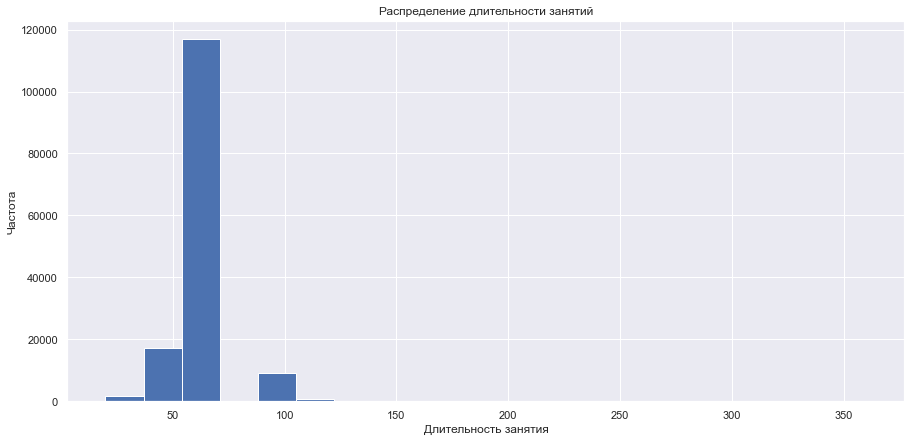

In [19]:
# проверим распределение длительности занятий
teachers_info_actual['lesson_duration'].hist(figsize=(15, 7), bins=20);
plt.title('Распределение длительности занятий')
plt.ylabel('Частота')
plt.xlabel('Длительность занятия')
plt.show()

In [20]:
# посчитаем долю аномально долгих занятий
len(teachers_info_actual[teachers_info_actual['lesson_duration'] > 120]) / len(teachers_info_actual)

0.0006714996368420331

Доля аномально долгих занятий незначительна. Их длительность остается в разумных пределах. Их наличие можно объяснить личными предпочтениями репетиторов. Не будем удалять эти выбросы.

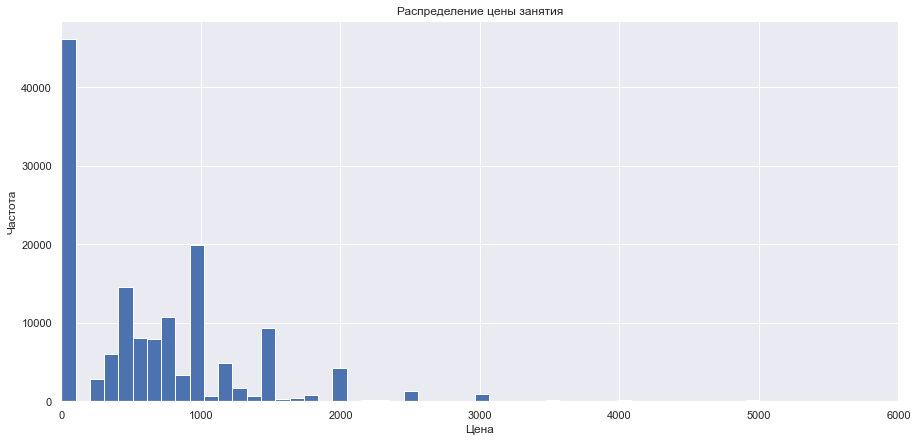

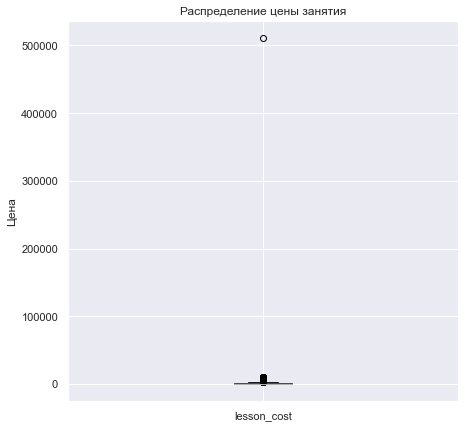

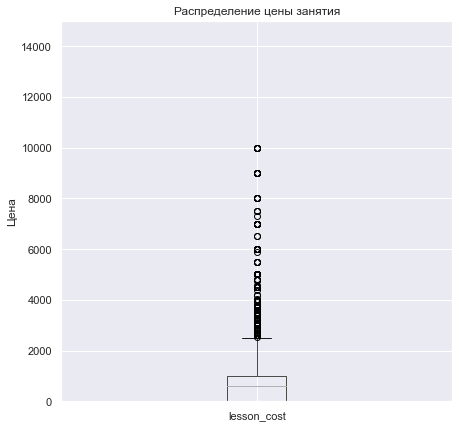

In [21]:
# проверим распределение цены занятия
teachers_info_actual['lesson_cost'].hist(figsize=(15, 7), bins=5000);
plt.title('Распределение цены занятия')
plt.ylabel('Частота')
plt.xlabel('Цена')
plt.xlim(0, 6000)
plt.show()

# проверим значительные выбросы
plt.figure(figsize=(7, 7))
teachers_info_actual.boxplot(column='lesson_cost')
plt.title('Распределение цены занятия')
plt.ylabel('Цена')
plt.show()

# проверим выбросы на реалистичных значениях
plt.figure(figsize=(7, 7))
teachers_info_actual.boxplot(column='lesson_cost')
plt.title('Распределение цены занятия')
plt.ylabel('Цена')
plt.ylim(0, 15000)
plt.show()

Нулевые цены вероятно появились оттого, что не все репетиторы заполняют эту графу. Высокие цены на занятия, но в пределах 10 000 рублей можно объяснить предпочтениями репетитора.
Удалим строки с ценой выше 10000 - это явная ошибка выгрузки или заполнения заявки.

In [22]:
# удалим выбросы в ценах
teachers_info_actual = teachers_info_actual[teachers_info_actual['lesson_cost'] <= 10000]

# проверим результат
teachers_info_actual.shape[0]

145941

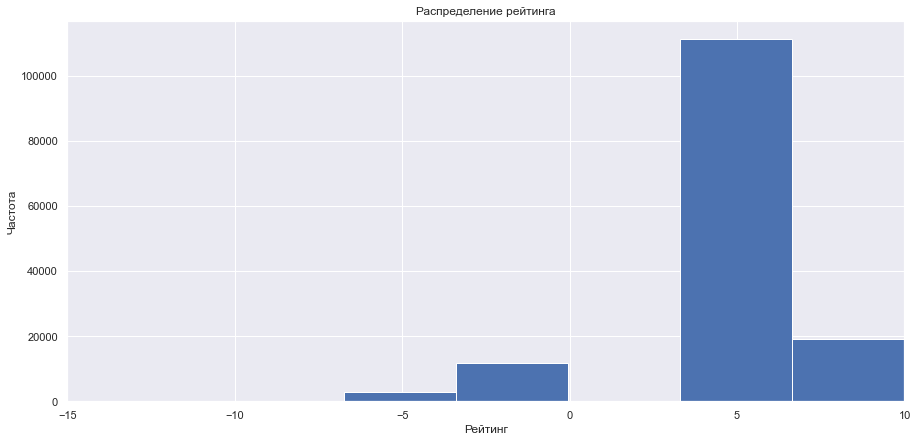

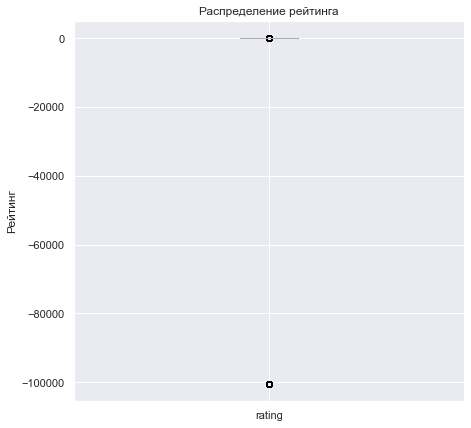

In [23]:
# проверим распределение рейтинга
teachers_info_actual['rating'].hist(figsize=(15, 7), bins=30000);
plt.title('Распределение рейтинга')
plt.ylabel('Частота')
plt.xlabel('Рейтинг')
plt.xlim(-15, 10)
plt.show()

# проверим значительные выбросы
plt.figure(figsize=(7, 7))
teachers_info_actual.boxplot(column='rating')
plt.title('Распределение рейтинга')
plt.ylabel('Рейтинг')
plt.show()

In [24]:
# проверим долю и количество значений рейтинга меньше -10
display(
    len(teachers_info_actual[teachers_info_actual['rating'] < -10]) / len(teachers_info_actual),
    len(teachers_info_actual[teachers_info_actual['rating'] < -10])
)

0.004501819228318293

657

In [25]:
# найдем нескольких репетиторов с аномально низким рейтингом
teachers_info_actual[teachers_info_actual['rating'] < -10].head()

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num
391,1419,2008-08-16 19:13:35,1965-03-16,2005-09-01,0,1,1,60,1000,1,1,0,-100500,0,6.199219,2,0,0,0,1,1,764.0,983.0,1,1,3340.0,5.000000,764.0,5
395,1425,2008-08-18 13:42:05,1986-02-03,2003-09-01,0,1,0,60,2100,1,1,0,-100500,0,3.861328,2,0,1,1,1,1,1970.0,3750.0,1,1,3080.0,4.898438,1970.0,9
1142,4063,2009-03-02 00:37:26,1973-05-24,2003-09-01,0,1,1,60,3000,1,1,0,-100500,0,8.875000,2,0,1,0,0,1,825.0,0.0,1,1,2694.0,4.800781,825.0,65
1350,4964,2009-05-07 00:14:02,1987-04-24,2006-09-01,0,1,1,60,4000,1,1,0,-100500,0,7.414062,2,0,1,1,1,1,1288.0,900.0,1,1,3262.0,5.000000,1288.0,1
1354,4980,2009-05-08 18:05:38,1962-02-03,1986-09-01,0,1,0,90,3500,0,1,0,-100500,0,16.359375,1,0,1,1,1,1,280.0,0.0,1,1,3222.0,5.000000,280.0,11


Доля и количество репетиторов с таким рейтингом незначительны. Прочие рейтинги этих репетиторов в норме. Вероятно аномальные значения вызваны ошибками. Удалим их.

In [26]:
# удалим строки с аномальным рейтингом
teachers_info_actual = teachers_info_actual[teachers_info_actual['rating'] >= -10]

# проверим результат
teachers_info_actual.shape[0]

145284

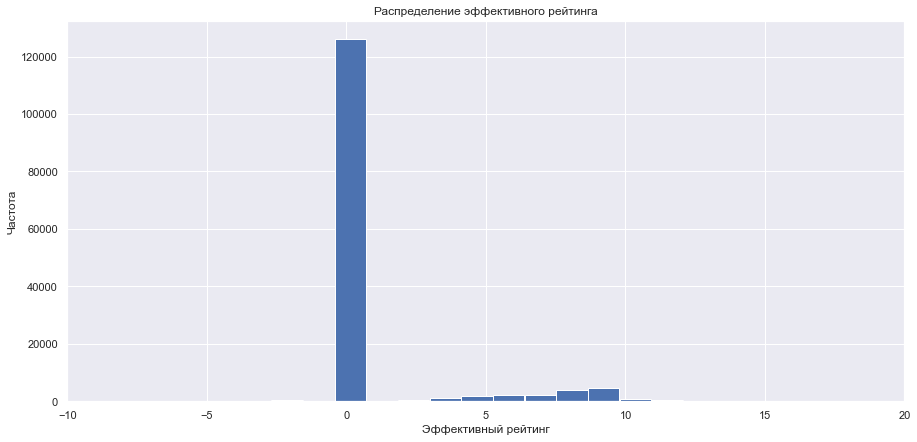

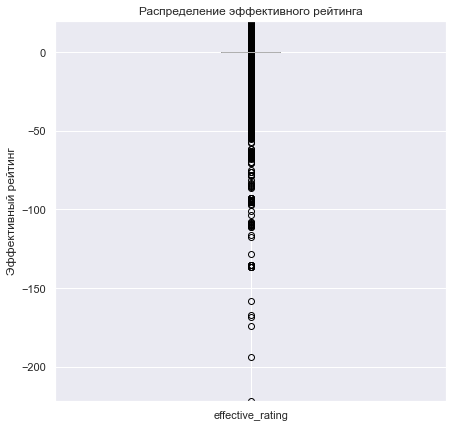

In [27]:
# проверим распределение эффективного рейтинга
teachers_info_actual['effective_rating'].hist(figsize=(15, 7), bins=10000);
plt.title('Распределение эффективного рейтинга')
plt.ylabel('Частота')
plt.xlabel('Эффективный рейтинг')
plt.xlim(-10, 20)
plt.show()

# проверим значительные выбросы
plt.figure(figsize=(7, 7))
teachers_info_actual.boxplot(column='effective_rating')
plt.title('Распределение эффективного рейтинга')
plt.ylabel('Эффективный рейтинг')
plt.ylim(-222, 20)
plt.show()

In [28]:
# проверим долю и количество значений рейтинга меньше -15 и больше 15
display(
    len(teachers_info_actual[(teachers_info_actual['effective_rating'] < -15) | (teachers_info_actual['effective_rating'] > 15)]) / len(teachers_info_actual),
    len(teachers_info_actual[(teachers_info_actual['effective_rating'] < -15) | (teachers_info_actual['effective_rating'] > 15)]),
# найдем нескольких репетиторов с аномально низким рейтингом
    teachers_info_actual[teachers_info_actual['effective_rating'] < -15].head()
)

0.005492690179235153

798

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num
11,103,2007-12-24 19:26:46,1989-06-09,2007-09-01,0,0,1,60,500,1,1,1,6,0,-26.671875,2,0,0,0,1,1,25.0,0.0,1,0,3682.0,4.300781,25.0,0
16,114,2007-12-24 19:26:46,1985-07-31,2004-09-01,0,1,1,60,1000,1,1,0,-1,0,-23.437500,2,0,1,0,1,1,125.0,0.0,1,1,3008.0,4.300781,125.0,0
40,182,2007-12-24 19:26:46,1974-01-10,1992-09-01,0,1,1,90,1000,1,1,1,7,0,-109.062500,1,0,0,0,1,1,100.0,0.0,1,0,3682.0,4.300781,100.0,0
72,269,2008-01-11 17:55:26,1984-05-08,2006-01-01,0,0,1,60,800,1,1,1,5,0,-67.125000,2,0,0,0,1,1,25.0,0.0,1,0,3682.0,4.300781,25.0,0
105,396,2008-02-08 13:05:49,1977-09-03,1999-09-01,0,1,1,60,1000,1,1,1,6,0,-135.375000,2,0,0,1,1,1,50.0,0.0,1,0,3682.0,4.300781,50.0,0


Доля и количество репетиторов с таким эффективным рейтингом незначительны. Удалим их, чтобы в дальнейшем не искажать средние значения при агрегации данных.

In [29]:
# удалим строки с аномальным эффективным рейтингом
teachers_info_actual = teachers_info_actual[(teachers_info_actual['effective_rating'] >= -15) & (teachers_info_actual['effective_rating'] <= 15)]

# проверим результат
teachers_info_actual.shape[0]

144486

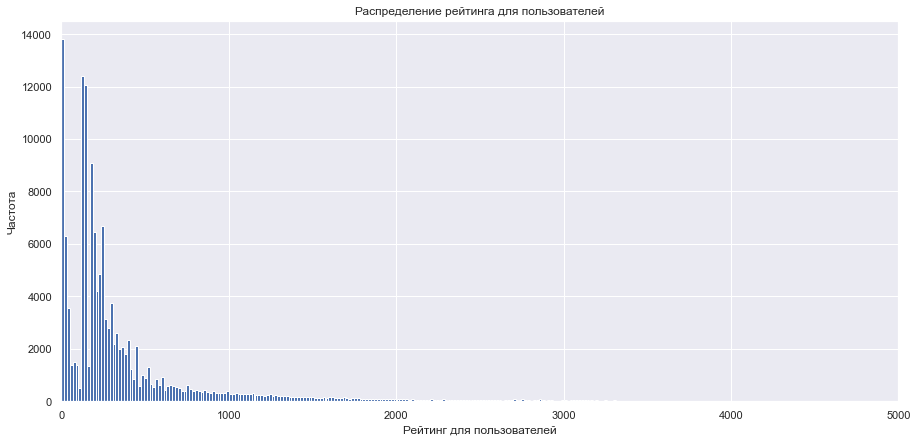

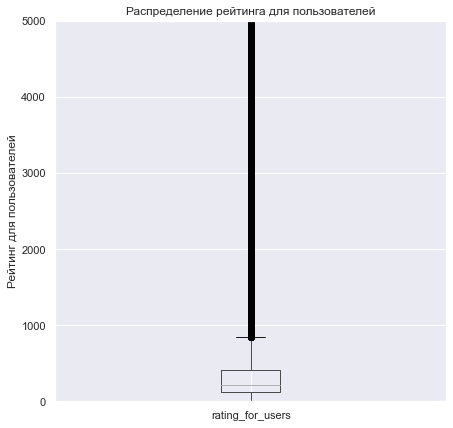

In [30]:
# проверим распределение рейтинга для пользователей
teachers_info_actual['rating_for_users'].hist(figsize=(15, 7), bins=1000);
plt.title('Распределение рейтинга для пользователей')
plt.ylabel('Частота')
plt.xlabel('Рейтинг для пользователей')
plt.xlim(0, 5000)
plt.show()

# проверим значительные выбросы
plt.figure(figsize=(7, 7))
teachers_info_actual.boxplot(column='rating_for_users')
plt.title('Распределение рейтинга для пользователей')
plt.ylabel('Рейтинг для пользователей')
plt.ylim(0, 5000)
plt.show()

In [31]:
# проверим долю и количество значений рейтинга для пользователей больше 4000
display(
    len(teachers_info_actual[teachers_info_actual['rating_for_users'] > 4000]) / len(teachers_info_actual),
    len(teachers_info_actual[teachers_info_actual['rating_for_users'] > 4000]),
# найдем нескольких репетиторов с аномально высокиим рейтингом
   teachers_info_actual[teachers_info_actual['rating_for_users'] > 4000].sample(5, random_state=RS)
)

0.003619727862907133

523

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num
30811,92046,2015-09-14 13:30:16.000,1984-03-21,2013-09-01,0,1,1,60,3000,0,1,1,7,0,0.0,2,0,1,1,1,1,5836.0,7184.0,1,1,2968.0,5.0,5836.0,5
88029,198013,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0,1,0,60,800,1,1,1,7,0,0.0,1,0,1,0,0,1,10920.0,7468.0,0,1,866.5,5.0,10896.0,10
43635,120783,2017-06-09 18:30:08.000,1984-09-13,2010-09-01,0,1,1,60,1500,1,1,1,7,0,0.0,1,0,1,1,1,1,5536.0,1886.0,1,1,2328.0,5.0,5484.0,58
29793,89698,2015-08-25 04:56:37.000,1995-06-07,2013-09-01,0,0,0,60,2500,1,1,1,5,0,0.0,1,0,1,1,1,1,4524.0,872.5,1,1,2858.0,5.0,4524.0,60
104990,226090,2021-02-16 17:01:59.053,1982-03-05,2000-09-01,0,1,0,60,600,1,1,1,5,0,0.0,2,0,1,0,0,1,5344.0,2432.0,0,1,480.0,5.0,5344.0,8


Похоже, что аномально высокий рейтинг для пользователей может быть заслужен репетиторами. Таких репетиторов совсем немного. Не будем удалять их.

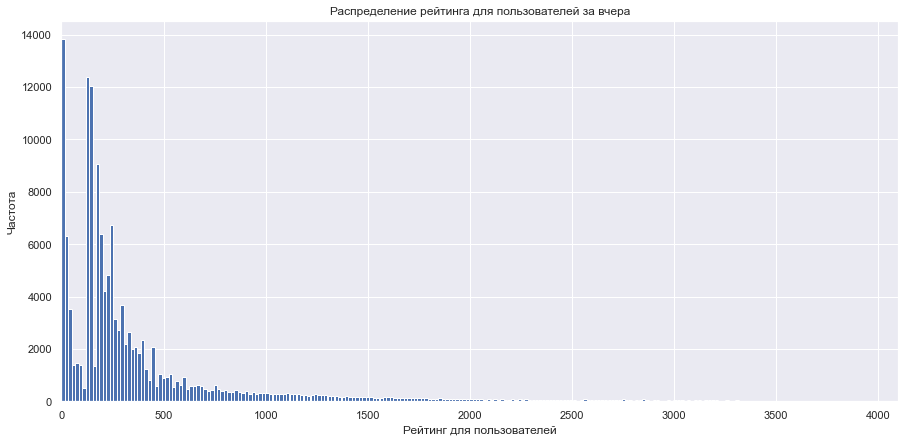

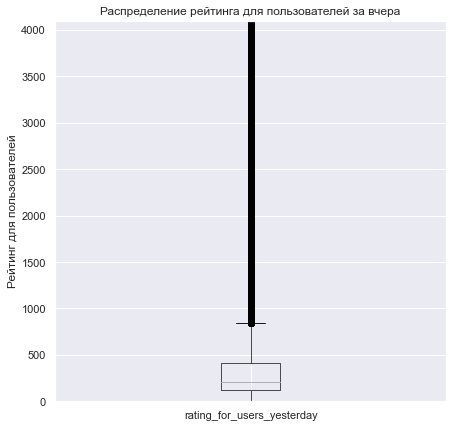

In [32]:
# проверим распределение рейтинга для пользователей за вчерашний день
teachers_info_actual['rating_for_users_yesterday'].hist(figsize=(15, 7), bins=1000);
plt.title('Распределение рейтинга для пользователей за вчера')
plt.ylabel('Частота')
plt.xlabel('Рейтинг для пользователей')
plt.xlim(0, 4100)
plt.show()

# проверим значительные выбросы
plt.figure(figsize=(7, 7))
teachers_info_actual.boxplot(column='rating_for_users_yesterday')
plt.title('Распределение рейтинга для пользователей за вчера')
plt.ylabel('Рейтинг для пользователей')
plt.ylim(0, 4100)
plt.show()

In [33]:
# проверим долю и количество значений рейтинга для пользователей больше 4000
display(
    len(teachers_info_actual[teachers_info_actual['rating_for_users_yesterday'] > 4000]) / len(teachers_info_actual),
    len(teachers_info_actual[teachers_info_actual['rating_for_users_yesterday'] > 4000]),
# найдем нескольких репетиторов с аномально высокиим рейтингом
   teachers_info_actual[teachers_info_actual['rating_for_users_yesterday'] > 4000].sample(5, random_state=RS+1)
)

0.0036128067771271956

522

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num
716,2536,2008-11-05 09:38:33,1972-09-02,1991-09-01,0,1,0,60,2500,1,1,1,6,0,12.179688,2,0,1,1,1,1,5068.0,1871.0,1,1,3340.0,4.898438,5068.0,85
32679,96489,2015-11-02 15:07:36,1957-06-21,1990-09-01,0,0,1,90,3000,1,1,1,7,0,0.000000,2,0,1,1,1,1,3992.0,2732.0,1,1,2774.0,4.898438,4032.0,49
32205,95463,2015-10-18 16:20:15,1965-11-12,1989-09-01,0,1,0,60,1500,1,1,1,7,0,0.000000,2,0,1,0,1,1,4200.0,520.0,1,1,2614.0,5.000000,4200.0,27
13374,46880,2012-12-18 21:31:37,1993-05-13,2011-09-01,0,1,1,60,3000,0,1,1,5,0,9.000000,2,0,1,1,0,1,4284.0,2644.0,1,1,3552.0,5.000000,4284.0,25
43635,120783,2017-06-09 18:30:08,1984-09-13,2010-09-01,0,1,1,60,1500,1,1,1,7,0,0.000000,1,0,1,1,1,1,5536.0,1886.0,1,1,2328.0,5.000000,5484.0,58


Ситуация с вчерашним рейтингом аналогична текущему рейтингу для пользователей. Не будем удалять большие значения.

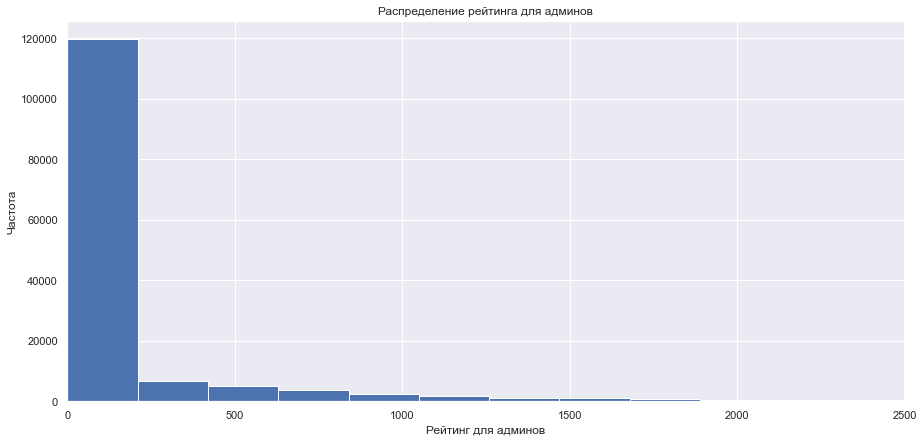

In [34]:
# проверим распределение рейтинга для админов
teachers_info_actual['rating_for_admin'].hist(figsize=(15, 7), bins=100);
plt.title('Распределение рейтинга для админов')
plt.ylabel('Частота')
plt.xlabel('Рейтинг для админов')
plt.xlim(0, 2500)
plt.show()

In [35]:
# проверим долю и количество значений рейтинга для пользователей больше 2000
display(
    len(teachers_info_actual[teachers_info_actual['rating_for_admin'] > 2000]) / len(teachers_info_actual),
    len(teachers_info_actual[teachers_info_actual['rating_for_admin'] > 2000]),
# найдем нескольких репетиторов с аномально высокиим рейтингом
   teachers_info_actual[teachers_info_actual['rating_for_admin'] > 2000].sample(5, random_state=RS)
)

0.012063452514430464

1743

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num
72806,170576,2019-07-11 18:20:19.957,1997-10-14,2018-09-01,0,1,0,60,0,1,1,1,5,0,0.00000,2,0,1,1,1,1,1105.0,2200.0,1,0,1562.0,5.000000,1105.0,1
101074,219659,2020-11-25 23:37:54.107,1966-07-23,2010-09-01,0,1,1,60,0,1,1,1,7,0,0.00000,1,0,1,1,1,1,2738.0,2288.0,0,1,1074.0,4.300781,2738.0,0
120096,253795,2022-02-03 15:54:49.147,1998-12-11,2016-09-01,0,0,1,60,0,0,1,1,5,0,0.00000,2,0,0,1,1,1,2000.0,2250.0,0,1,639.5,4.300781,2000.0,0
80240,184354,2019-10-29 20:20:14.873,1990-07-07,2013-09-01,0,1,0,60,1200,0,1,1,5,0,0.00000,2,0,1,1,1,1,6252.0,3542.0,0,1,1424.0,5.000000,6212.0,1
8606,31363,2011-09-29 22:49:00.000,1957-03-11,1980-09-01,0,1,0,90,2500,0,1,1,6,0,8.84375,2,0,1,1,1,1,3412.0,2382.0,1,1,2990.0,4.898438,3412.0,60


Большая часть репетиторов имеет нулевой рейтинг для админов. Похоже, что аномально высокий рейтинг - не ошибка. Таких репетиторов не так много, но они могут оказать влияние на предсказания. Не будем удалять их.

## Анализ заявок

In [36]:
# изменим формат дат в orders
orders['order_date'] = pd.to_datetime(
    orders['order_date'],
    errors='coerce'
)

# проверим результат
orders[['id', 'order_date']].dtypes

id                     int32
order_date    datetime64[ns]
dtype: object

In [37]:
# проверим даты на аномалии
orders['order_date'].describe(include='all')

count                        1190958
unique                       1190746
top       2021-09-16 03:58:15.883000
freq                               4
first     2021-09-01 00:12:16.713000
last      2023-11-05 23:59:45.687000
Name: order_date, dtype: object

In [38]:
# удалим строки с пропусками в order_date
orders.dropna(subset=['order_date'], inplace=True)

# проверим результат
orders[['id', 'order_date']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190958 entries, 0 to 437215
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   id          1190958 non-null  int32         
 1   order_date  1190958 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 22.7 MB


Даты заявок корректны.

In [39]:
# проанализируем остальные признаки заявок
check_data(orders)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190958 entries, 0 to 437215
Data columns (total 23 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1190958 non-null  int32         
 1   order_date               1190958 non-null  datetime64[ns]
 2   subject_id               1180633 non-null  float32       
 3   purpose                  1024538 non-null  object        
 4   lesson_price             1190958 non-null  int32         
 5   lesson_duration          1190958 non-null  int32         
 6   home_metro_id            642006 non-null   float32       
 7   status_id                1190958 non-null  int32         
 8   planned_lesson_number    1190958 non-null  int32         
 9   pupil_category_new_id    1031652 non-null  float32       
 10  lessons_per_week         1190958 non-null  int32         
 11  minimal_price            1190958 non-null  int32         
 12  t

None

id                         1190958
order_date                 1190746
subject_id                      27
purpose                     294447
lesson_price                   346
lesson_duration                  6
home_metro_id                 2323
status_id                       15
planned_lesson_number            5
pupil_category_new_id           16
lessons_per_week                 8
minimal_price                  168
teacher_sex                      4
teacher_experience_from         40
teacher_experience_to           65
lesson_place_new                 8
pupil_knowledgelvl               5
teacher_age_from                83
teacher_age_to                 106
chosen_teachers_only             2
no_teachers_available            2
original_order_id           314928
is_display_to_teachers           2
dtype: int64

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
count,1.190958e+06,1190958,1.180633e+06,1024538,1.190958e+06,1.190958e+06,642006.000000,1.190958e+06,1.190958e+06,1.031652e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,1.190958e+06,5.822370e+05,1.190958e+06
unique,NaN,1190746,NaN,294447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2021-09-16 03:58:15.883000,NaN,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,11443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-09-01 00:12:16.713000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2023-11-05 23:59:45.687000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.340441e+06,NaN,1.007083e+01,NaN,2.008935e+03,6.065017e+01,792.196533,1.314519e+01,8.302389e+00,9.918077e+00,3.015530e+00,2.018417e+02,2.080853e+00,1.468021e+00,8.938670e-01,2.857694e+00,3.891271e-01,8.331939e+00,1.740780e+01,2.236519e-02,9.085543e-02,2.325780e+06,9.641423e-01
std,3.446780e+05,NaN,7.652966e+00,NaN,9.166609e+05,7.254112e+00,670.186951,4.249729e+00,3.561463e+00,3.663970e+00,1.610936e+00,9.270897e+03,1.084934e+00,2.784489e+00,8.375669e+00,1.796165e+00,8.475272e-01,1.340332e+01,1.001052e+02,1.478682e-01,2.874035e-01,3.481197e+05,1.859353e-01
min,1.742636e+06,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e+01,-1.100000e+02,0.000000e+00,0.000000e+00,2.630000e+02,0.000000e+00
25%,2.041215e+06,NaN,3.000000e+00,NaN,5.000000e+02,6.000000e+01,228.000000,7.000000e+00,1.000000e+01,8.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.022598e+06,1.000000e+00


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,NaN,16,0,NaN,0,0,3,0,0,0,0,0,0,0,0,2294000.0,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,NaN,7,0,NaN,0,0,3,0,0,0,0,0,0,0,0,2294000.0,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,NaN,16,7,14.0,2,0,3,0,0,4,0,0,0,0,0,NaN,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,NaN,16,10,10.0,3,0,3,5,0,4,0,20,90,0,0,2293804.0,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,122.0,16,0,NaN,0,0,0,0,0,2,0,0,0,0,0,NaN,1


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
364536,2207807,2022-09-20 12:18:29.897,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,NaN,16,10,9.0,2,0,2,5,0,4,0,25,45,0,0,2194163.0,1
328467,2916479,2023-10-26 18:56:19.017,9.0,Разделы: электротехника.\nКатегория ученика: с...,700,60,NaN,3,10,14.0,3,500,3,0,0,4,0,0,0,0,1,NaN,1
71674,2365735,2022-12-09 20:05:07.977,10.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,3500,60,34.0,6,10,12.0,2,0,3,0,0,1,0,0,0,0,0,NaN,1
135948,1977539,2022-02-21 07:37:17.777,16.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,500,60,1208.0,16,10,10.0,2,0,2,0,0,2,0,0,0,0,1,NaN,1
14900,1757632,2021-09-08 08:13:19.250,8.0,None,0,60,NaN,16,0,NaN,0,0,3,0,0,0,0,0,0,0,0,1757618.0,1


Дубликатов строк: 0


In [40]:
# функция проверки проверки пропусков в столбце orders
def check_na(col):
    # отфильтруем строки с пропущенными значениями в столбце col
    na_rows = orders[col.isna()]
    # найдем среднее и медиану только для этих строк
    display(na_rows.agg(['mean', 'median']))

In [41]:
# проверим пропуски в subject_id
check_na(orders['subject_id'])

,id,order_date,subject_id,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
mean,2.233168e+06,2022-08-30 18:57:18.534147328,NaN,88.784697,60.0,770.90863,12.377046,0.166877,12.38213,0.101211,7.738983,2.26092,0.027119,0.722131,0.140533,0.000387,0.92707,3.602615,0.0,0.000291,2251064.0,0.947119
median,2.222548e+06,2022-09-27 19:43:25.470000128,NaN,0.000000,60.0,666.50000,16.000000,0.000000,14.00000,0.000000,0.000000,3.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,2258024.0,1.000000


Значительная часть заявок с пропуском в предмете содержат нули и пропуски в прочих столбцах. Ноль не используется в качестве id предмета, поэтому будет корректно запонить нулями пропуски в subject_id.

In [42]:
# заполним нулями пропуски в предмете
orders['subject_id'].fillna(0, inplace=True)

# проверим результат
orders[orders['subject_id'].isna()]['subject_id']

Series([], Name: subject_id, dtype: float32)

In [43]:
# выведем сам частые цели в заявках
orders['purpose'].value_counts().head(30)

Разделы:  школьный курс.\nДополнения: ОГЭ (ГИА).\nКатегория ученика: школьник 9 класса.\nЦель занятий: подготовка к ОГЭ.                                            11443
Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 класс.\nДо экзамена осталось: Несколько месяцев.\n                                                                     10586
Разделы:  школьный курс.\nДополнения: ЕГЭ.\nКатегория ученика: школьник 11 класса.\nЦель занятий: подготовка к ЕГЭ.                                                  9757
Цели: помощь по школьной программе.\nКатегория ученика: 8 класс.\n                                                                                                   5678
Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 класс.\nДо экзамена осталось: Год и больше.\n                                                                           5286
Цели: помощь по школьной программе.\nКатегория ученика: 7 класс.\n                                                                                    

В целях прослеживается разделение на группы. В дальнейшем можно разделить этот признак на несколько отдельных либо использовать как есть. 

In [44]:
# проверим пропуски в purpose
check_na(orders['purpose'])

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
mean,2.131140e+06,2022-06-19 13:12:24.205515520,9.32132,NaN,99.723879,60.001893,705.440002,10.004338,0.656195,10.378637,0.253125,2.944922,1.156237,0.315659,2.088631,0.494898,0.016326,0.725436,2.895716,0.000709,0.000391,2127388.5,0.992134
median,2.055327e+06,2022-05-11 17:08:35.380000000,8.00000,NaN,0.000000,60.000000,481.000000,7.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2051313.5,1.000000


Вероятно пропуски в purpose появились из-за того, что это поле было пропущено при создании заявки учеником. Заполним пропуски "заглушкой".

In [45]:
# заполним пропуски
orders['purpose'].fillna('Не заполнено', inplace=True)

# проверим результат
orders['purpose'].isna().sum()

0

Значительная часть заявок с пропуском в цели содержат нули и пропуски в прочих столбцах. Мы не будем удалять строки с пропусками - они могут говорить о том, что заявка заполнена плохо и скорее всего не будет оплачена. Далее рассмотрим столбец lesson_price: в нем много крупных значений. Исключим их из графика для удобства анализа:

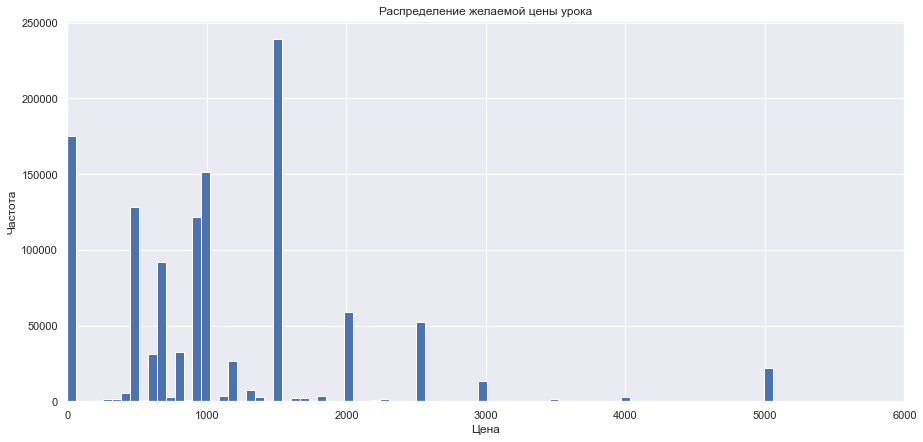

In [46]:
# проверим распределение ненулевых значений в lesson_price 
orders[orders['lesson_price'] < 10000]['lesson_price'].hist(figsize=(15, 7), bins=150);
plt.title('Распределение желаемой цены урока')
plt.ylabel('Частота')
plt.xlabel('Цена')
plt.xlim(0, 6000)
plt.show()

In [47]:
# проверим крупные значения lesson_price
display(
    len(orders[orders['lesson_price'] > 6000]) / len(orders),
    orders[orders['lesson_price'] > 6000].agg(['mean', 'median']),
    orders[orders['lesson_price'] > 6000].sample(5, random_state=RS)
)

0.0011268239518102234

,id,order_date,subject_id,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
mean,2.247327e+06,2022-09-11 03:56:42.864273408,11.175857,817199.584948,33.397914,591.563538,14.576751,8.982116,10.235112,4.561848,16273.771237,2.589419,0.864382,0.558867,2.134873,0.615499,9.704173,19.776453,0.020119,0.115499,2270853.25,0.963487
median,2.199068e+06,2022-09-16 03:45:53.951500032,9.000000,14000.000000,0.000000,238.000000,16.000000,10.000000,12.000000,4.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2252612.00,1.000000


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
275047,2118290,2022-07-28 21:28:48.457,2.0,Разделы: общий курс.\nКатегория ученика: 2 уче...,7500,135,35.0,16,10,12.0,4,0,2,5,0,1,2,35,60,0,0,2118253.0,1
227797,2815808,2023-09-20 21:43:02.017,21.0,Разделы: все школьные предметы.\nКатегория уче...,100000,60,NaN,16,10,9.0,7,0,3,5,0,1,0,0,0,0,1,NaN,1
27015,1769860,2021-09-13 19:36:59.657,11.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,12000,60,NaN,16,10,15.0,4,1000,2,0,0,4,0,0,0,0,0,NaN,1
100045,1941627,2022-01-28 11:07:00.020,21.0,"Разделы: балет, хореография.\nКатегория ученик...",35000,0,848.0,16,10,16.0,7,0,3,0,0,1,0,0,0,0,0,NaN,1
319053,2907065,2023-10-23 16:35:44.070,21.0,"Разделы: дефектолог, техника речи.\nКатегория ...",7000,60,261.0,8,10,15.0,3,0,3,0,0,1,0,0,0,0,0,NaN,1


Выбросы в lesson_price составляют незначительную долю строк. Аномально высокие значения могут свидетельствовать о бесперспективной заявке, поэтому стоит их оставить.

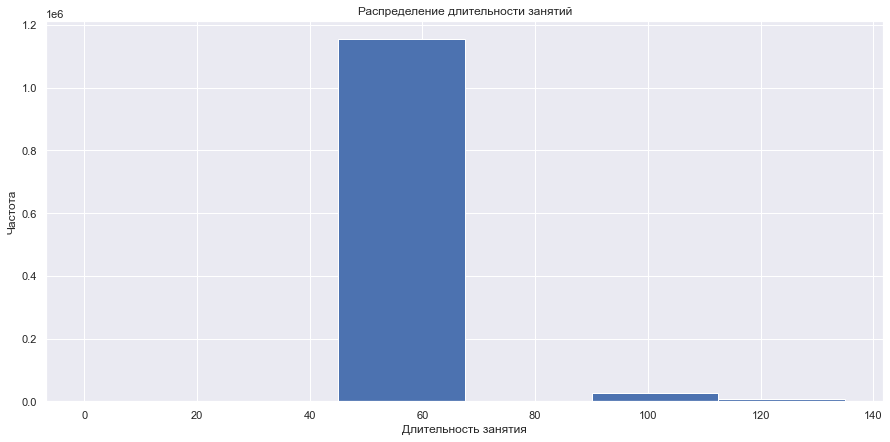

In [48]:
# проверим распределение lesson_duration
orders['lesson_duration'].hist(figsize=(15, 7), bins=6);
plt.title('Распределение длительности занятий')
plt.ylabel('Частота')
plt.xlabel('Длительность занятия')
plt.show()

Длительность занятия имеет адекватные значения.

Пропуски в home_metro_id говорят о том, что поле не заполнялось учеником. Это полезная информация для предсказания. Возможно, ученик находится в городе, где нет метро. Строки с пропусками ни в коем случае нельзя удалять. Заполним их нулевыми значениями.

In [49]:
# заполним пропуски
orders['home_metro_id'].fillna(0, inplace=True)

# проверим результат
orders['home_metro_id'].isna().sum()

0

In [50]:
# проверим пропуски в возрасте ученика
check_na(orders['pupil_category_new_id'])

,id,order_date,subject_id,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers
mean,2.146806e+06,2022-06-30 17:59:40.189102336,9.277058,54.556815,59.977967,133.74379,10.076143,0.313868,NaN,0.10117,10.465438,1.196477,0.178926,2.253223,0.395277,0.003371,0.666579,2.461395,0.001099,0.004677,2140997.75,0.990647
median,2.090408e+06,2022-06-22 10:52:54.137999872,8.000000,0.000000,60.000000,0.00000,7.000000,0.000000,NaN,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2083026.00,1.000000


Пропуски в возрасте ученика говорят о том, что поле скорее всего не заполнялось. Это полезная информация для предсказания. Заполним пропуски нулевыми значениями.

In [51]:
# заполним пропуски
orders['pupil_category_new_id'].fillna(0, inplace=True)

# проверим результат
orders['pupil_category_new_id'].isna().sum()

0

Заявки с пропуском в original_order_id - оригинальные заявки, недубли. Соответственно original_order_id не должны совпадать с id для одних и тех же строк. Проверим это:

In [52]:
# проверим original_order_id и id на совпадения 
orders[orders['original_order_id'] == orders['id']]['id'].count()

848

В заявки с совпадающими id явно попала ошибка. Чтобы избежать возможной утечки данных, удалим эти строки.

In [53]:
# удалим заявки с ошибочными id
orders = orders[orders['original_order_id'] != orders['id']]

# проверим результат
orders.shape[0]

1190110

Прочие признаки заявок также имеют выбросы, но при этом вполне адекватны и могут быть использованы для обучения. Аномальные значения вероятно будут свидетельствовать о бесперспективности заявки.

In [54]:
# после заполнения пропусков проверим строки датасета на дубликаты
orders.duplicated().sum()

0

**Вывод:**

Мы убрали небольшую долю выбросов в датасете репетиторов. Но не стали удалять выбросы в данных заявок. Они могут говорить о нерелевантном заполнении заявки и о ее бесперпективности. Пустые значения и пропуски тоже могут свидетельствовать о бесперспективности заявки.

# Объединение данных

## Добавление дат заявок к подходящим репетититорам

Добавим даты заявок в датасет с подходящими репетиторами suitable_teachers. Это поможет нам вычислить актуальные данные на момент подачи заявки: возраст и стаж репетитора, срок с момента регистрации и срок с последнего захода на сайт.

In [55]:
# функция добавляет даты заявок в suitable_teachers и возвращает новый датасет
def get_actual_teacher_dates(orders, suitable_teachers):
    orders1 = orders[['id', 'order_date']].copy()
    # переименуем столбец для корректного объединения
    orders1.rename(columns={'id': 'order_id'}, inplace=True)
    # добавим даты
    suitable_teachers_actual_dates = suitable_teachers.merge(orders1, on='order_id')    
    return suitable_teachers_actual_dates

In [56]:
# выведем количество строк и шапку таблицы до объединения
display(
    suitable_teachers.head(3),
    suitable_teachers.shape)

,teacher_id,order_id,enable_auto_assign,enable_assign
0,82583,1742711,1,1
1,125057,1742713,0,0
2,231211,1742713,0,0


(20271045, 4)

In [57]:
# добавим даты в suitable_teachers
suitable_teachers = get_actual_teacher_dates(orders, suitable_teachers)

# проверим результат
display(
    suitable_teachers.head(3),
    suitable_teachers.shape)

,teacher_id,order_id,enable_auto_assign,enable_assign,order_date
0,82583,1742711,1,1,2021-09-01 07:45:37.413
1,125057,1742713,0,0,2021-09-01 07:59:44.327
2,231211,1742713,0,0,2021-09-01 07:59:44.327


(19927458, 5)

После добавления дат мы потеряли примерно 1,7% строк. Это связано с тем, что suitable_teachers содержит больше уникальных id заявок, чем датасет orders. Далее объединим teachers_info и suitable_teachers.

In [58]:
# выведем размер и размерность присоединяемого датасета
teachers_info_actual.shape

(144486, 29)

## Объединение данных всех репетиторов и подходящих репетиторов

In [59]:
# объединим данные репетиторов и информацию о подходящих для заявок репетиторах.
order_teachers_info = suitable_teachers.merge(teachers_info_actual, on='teacher_id')

# проверим результат
display(
    order_teachers_info.head(3),
    order_teachers_info.shape)

,teacher_id,order_id,enable_auto_assign,enable_assign,order_date,reg_date,birth_date,teaching_start_date,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num
0,82583,1742711,1,1,2021-09-01 07:45:37.413,2015-02-16 14:04:03,1981-02-02,2000-09-01,0,1,0,45,600,0,1,1,5,0,0.0,1,0,0,1,1,1,150.0,0.0,1,1,3180.0,4.300781,150.0,0
1,82583,2303834,0,0,2022-11-07 09:57:28.980,2015-02-16 14:04:03,1981-02-02,2000-09-01,0,1,0,45,600,0,1,1,5,0,0.0,1,0,0,1,1,1,150.0,0.0,1,1,3180.0,4.300781,150.0,0
2,82583,2341690,0,0,2022-11-25 20:14:01.163,2015-02-16 14:04:03,1981-02-02,2000-09-01,0,1,0,45,600,0,1,1,5,0,0.0,1,0,0,1,1,1,150.0,0.0,1,1,3180.0,4.300781,150.0,0


(19717614, 33)

Незначительное сокращение строк объединенного датасета связано с тем, что мы ранее удалили часть строк из teachers_info_actual. Далее создадим признаки с использованием дат.

In [60]:
def add_teacher_periods(order_teachers_info1):
    """
    Функция принимает датасет с датами заказа, датой рождения репетитора, 
    датой начала преподавания, датой регистрации.
    Функция возвращает датасет с признаками возраста и стажа репетитора, 
    срока с момента регистрации. 
    Функция округляет значения до целых лет и приводит их к целочисленному типу.
    """
    # вычтем из даты заказа дату рождения
    order_teachers_info['teacher_age'] = \
    np.subtract(
        order_teachers_info1['order_date'].values.astype('datetime64[D]'), 
        order_teachers_info1['birth_date'].values.astype('datetime64[D]')
    ).astype('timedelta64[Y]').astype('int8')  # округлим до целых лет
    
    # вычтем из даты заказа дату начала преподавания
    order_teachers_info['teacher_experience'] = \
    np.subtract(
        order_teachers_info1['order_date'].values.astype('datetime64[D]'), 
        order_teachers_info1['teaching_start_date'].values.astype('datetime64[D]')
    ).astype('timedelta64[Y]').astype('int8')  # округлим до целых лет

    # вычтем из даты заказа дату регистрации
    order_teachers_info['teacher_reg_period'] = \
    np.subtract(
        order_teachers_info1['order_date'].values.astype('datetime64[D]'), 
        order_teachers_info1['reg_date'].values.astype('datetime64[D]')
    ).astype('timedelta64[Y]').astype('int8')  # округлим до целых лет
    
    return order_teachers_info

In [61]:
%%time
# добавим периоды
order_teachers_info = add_teacher_periods(order_teachers_info)

# проверим результат
order_teachers_info[[
    'order_date',
    'birth_date',
    'teaching_start_date',
    'reg_date',
    'teacher_age',
    'teacher_experience',
    'teacher_reg_period'
]].head()

Wall time: 7.06 s


,order_date,birth_date,teaching_start_date,reg_date,teacher_age,teacher_experience,teacher_reg_period
0,2021-09-01 07:45:37.413,1981-02-02,2000-09-01,2015-02-16 14:04:03,40,20,6
1,2022-11-07 09:57:28.980,1981-02-02,2000-09-01,2015-02-16 14:04:03,41,22,7
2,2022-11-25 20:14:01.163,1981-02-02,2000-09-01,2015-02-16 14:04:03,41,22,7
3,2022-12-05 12:07:43.257,1981-02-02,2000-09-01,2015-02-16 14:04:03,41,22,7
4,2022-12-05 17:17:00.010,1981-02-02,2000-09-01,2015-02-16 14:04:03,41,22,7


In [62]:
# удалим использованные столбцы из датасета
order_teachers_info.drop(
    [
        'teacher_id',
        'order_date',
        'birth_date',
        'teaching_start_date',
        'reg_date'
    ],
    axis=1,
    inplace=True
)

# проверим результат
order_teachers_info.head(1)

,order_id,enable_auto_assign,enable_assign,is_email_confirmed,is_home_lessons,is_external_lessons,lesson_duration,lesson_cost,status_display,is_confirmed,is_display,rating,is_cell_phone_confirmed,effective_rating,sex,amount_to_pay,is_remote_lessons,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,is_edited,orders_allowed,display_days,star_rating,rating_for_users_yesterday,review_num,teacher_age,teacher_experience,teacher_reg_period
0,1742711,1,1,0,1,0,45,600,0,1,1,5,0,0.0,1,0,0,1,1,1,150.0,0.0,1,1,3180.0,4.300781,150.0,0,40,20,6


## Объединение данных репетиторов и заявок

In [63]:
# напишем функцию агрегации признаков репетиторов
def group_teachers_features(order_teachers_info):
    # сгруппируем значения для каждой заявки
    teachers_grouped = order_teachers_info.groupby('order_id').agg(
        {
            'enable_auto_assign': 'mean', 
            'enable_assign': 'mean',
            'is_email_confirmed': 'mean',
            'is_home_lessons': 'mean',
            'is_external_lessons': 'mean',
            'lesson_duration': ['mean', 'min', 'max'],
            'lesson_cost': ['mean', 'min', 'max'],
            'status_display': 'mean',
            'is_confirmed': 'mean',
            'is_display': 'mean',
            'rating': ['mean', 'median'],
            'is_cell_phone_confirmed': 'mean',
            'effective_rating': ['mean', 'median'],
            'sex': 'median',
            'amount_to_pay': 'median',
            'is_remote_lessons': 'mean',
            'show_on_map': 'mean',
            'send_mailing': 'mean',
            'send_suitable_orders': 'mean',
            'rating_for_users': ['mean', 'median'],
            'rating_for_admin': 'mean',
            'is_edited': 'mean',
            'orders_allowed': 'mean',
            'display_days': 'mean',
            'star_rating': 'mean',
            'rating_for_users_yesterday': 'mean',
            'review_num': 'mean',
            'teacher_age': ['mean', 'min', 'max'],
            'teacher_experience': ['mean', 'min', 'max'],
            'teacher_reg_period': 'mean'
        }
    )
    # преобразуем двойные наименования столбцов в одинарные
    teachers_grouped.columns = ['_'.join(col) for col in teachers_grouped.columns]

    # создадим колонку с id заявки
    teachers_grouped['id'] = teachers_grouped.index

    return teachers_grouped

In [64]:
%%time
# сгруппируем значения
teachers_grouped = group_teachers_features(order_teachers_info)

# проверим результат
display(
    teachers_grouped.head(2),
    teachers_grouped.shape
)

,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean,id
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1742638,0.538462,0.0,0.0,0.461538,0.846154,60.0,60,60,776.923077,0,2500,0.769231,1.0,0.769231,5.692308,6.0,0.0,0.922852,0.0,1.0,0,0.846154,0.846154,0.692308,1.0,994.0,833.0,519.0,0.538462,1.0,1824.0,4.714844,1022.0,6.307692,25.0,21,31,5.769231,3,14,3.692308,1742638
1742639,1.000000,1.0,0.0,0.000000,1.000000,60.0,60,60,1000.000000,1000,1000,1.000000,1.0,1.000000,6.000000,6.0,0.0,0.000000,0.0,2.0,0,1.000000,1.000000,1.000000,1.0,805.5,805.5,614.0,0.000000,1.0,1102.0,4.898438,805.5,6.000000,32.0,32,32,8.000000,8,8,1.000000,1742639


(831452, 42)

Wall time: 54.4 s


In [65]:
# объединим данные
df = orders.merge(teachers_grouped, on='id')

# проверим результат
display(
    df.head(2),
    df.shape
)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean
0,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,0.0,16,7,14.0,2,0,3,0,0,4,0,0,0,0,0,NaN,1,0.0,0.2,0.0,1.000000,0.600000,60.0,60,60,574.0,500,670,0.6,1.0,1.0,6.400000,7.0,0.0,0.0,0.0,2.0,0,1.0,1.0,1.0,1.0,1072.0,1037.0,309.0000,0.800000,1.000000,2136.0,4.917969,1133.0,26.200000,57.600000,35,77,28.400000,6,43,4.6
1,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,0.0,16,10,10.0,3,0,3,5,0,4,0,20,90,0,0,2293804.0,1,0.0,0.0,0.0,0.666667,0.333333,70.0,60,90,700.0,400,1000,0.0,1.0,1.0,6.666667,7.0,0.0,0.0,0.0,2.0,0,1.0,1.0,1.0,1.0,588.5,525.0,93.3125,0.666667,0.666667,2230.0,4.964844,588.5,7.666667,58.333333,53,67,26.666667,15,42,5.0


(831452, 64)

**Вывод:** 

Предварительно мы добавили даты заявок в датасет с подходящими репетиторами suitable_teachers. Это помогло нам вычислить актуальные данные на момент подачи заявки: возраст и стаж репетитора, срок с момента регистрации и срок с последнего захода на сайт. Также мы объединили данные репетиторов и подходящих репетиторов. Затем агрегировали информацию о репетиторах для каждой заявки и добавили получившиеся признаки к заявкам.

# Обработка признаков

## Синтез признаков

Присвоим заявке статус оплачено, если хотя бы один из дублей заявки был оплачен. Заполним пропуски в original_order_id. Этот столбец поможет нам разделить датасет на выборки так, чтобы в одну выборку попадали все дубликаты заявки. Так мы избежим возможной утечки целевого признака. Также мы сможем заполнить целевой признак для дублей заявок.

In [66]:
# функция создает целевой признак и заполняет пропуски в original_order_id
def get_target(data):
    df = data.copy()
    # сначала создадим целевой признак без учета дублей
    df['target'] = df['status_id'].apply(lambda x: 1 if x in [5, 6, 13, 14, 15] else 0)
    
    # заполним пропуски в original_order_id для первоначальных заявок
    df.loc[df['original_order_id'].isna(), 'original_order_id'] = df.loc[df['original_order_id'].isna(), 'id']

    # суммируем все значения целевого признака для каждого кластера заявок
    target_dict = df.groupby('original_order_id')['target'].sum()
    # присваиваем значение целевого признака всем дублям
    df['target'] = df['original_order_id'].map(lambda x: 1 if target_dict.get(x, 0) > 0 else 0)

    return df

In [67]:
# получим целевой признак и заполним пропуски в original_order_id
df = get_target(df)

# проверим результат
display(
    df.loc[df['original_order_id'].isna(), 'original_order_id'],
    df['target'].head(),
    df['target'].mean()
)

Series([], Name: original_order_id, dtype: float32)

0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64

0.3540998157440237

## Разделение на выборки

In [68]:
# функция разбивает датасет на выборки так, чтобы дубли заявок всегда оставались в одной выборке
def split_data(df, train_size, random_state=None):

    # найдем кластеры заявок через id первоначальных заявок
    unique_clusters = df['original_order_id'].unique()
    
    # укажем пропорцию разбиения на выборки
    train_clusters_count = int(train_size * len(unique_clusters))

    # перемешаем кластеры в случайном порядке, если указан параметр random_state
    if random_state is not None:
        np.random.seed(random_state)
        np.random.shuffle(unique_clusters)
    
    # выберем кластеры для тренировочной и тестовой выборок
    train_clusters = unique_clusters[:train_clusters_count]
    test_clusters = unique_clusters[train_clusters_count:]
    
    # разделим датасет на выборки train и test
    train = df[df['original_order_id'].isin(train_clusters)]
    test = df[df['original_order_id'].isin(test_clusters)]

    # перемешаем строки в train и test
    if random_state is not None:
        train = train.sample(frac=1, random_state=random_state).reset_index(drop=True)
        test = test.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # выделим целевой признак
    X_train = train.drop(['target'], axis=1)
    y_train = train['target']
    X_test = test.drop(['target'], axis=1)
    y_test = test['target']

    return X_train, y_train, X_test, y_test

In [69]:
# разделим датасет на выборки
X_train, y_train, X_test, y_test = split_data(df, 0.75, RS)

# проверим результат
display(
    X_train.head(),
    X_train.shape,
    y_train.shape,
    X_test.head(),
    X_test.shape,
    y_test.shape
)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean
0,2877509,2023-10-11 17:54:39.093,1.0,Цели: объяснить темы.\nКатегория ученика: Взро...,700,60,0.0,11,10,15.0,3,0,2,0,0,4,0,0,0,0,0,2877382.0,0,0.000000,0.000000,0.0,0.500000,0.500000,58.333333,45,60,569.444444,0,700,0.666667,1.0,0.944444,5.111111,5.0,0.0,0.897949,0.0,2.0,0,0.944444,0.833333,0.555556,1.000000,1348.0,1244.0,552.5,0.277778,0.944444,1277.0,4.882812,1345.0,15.388889,35.944444,20,77,14.444444,2,57,3.333333
1,2355554,2022-12-03 19:28:38.273,2.0,Разделы: общий курс.\nКатегория ученика: школь...,1500,60,26.0,6,10,4.0,4,700,2,7,0,1,2,25,0,0,0,2355501.0,1,0.000000,0.041667,0.0,0.583333,1.000000,60.625000,45,90,906.250000,0,2000,0.750000,1.0,0.875000,6.041667,6.0,0.0,3.195312,0.0,2.0,0,0.666667,0.666667,0.958333,0.958333,805.5,546.0,576.5,0.791667,1.000000,2572.0,4.867188,805.0,6.833333,40.375000,25,66,15.708333,6,33,7.291667
2,2419422,2023-01-16 17:17:47.397,16.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,800,60,0.0,6,10,10.0,3,0,2,0,0,4,0,16,50,0,0,2419422.0,1,0.000000,0.071429,0.0,0.571429,0.714286,62.142857,60,90,517.857143,0,800,0.857143,1.0,1.000000,5.642857,5.5,0.0,0.835938,0.0,2.0,0,1.000000,0.928571,0.857143,1.000000,870.5,776.0,447.0,0.357143,1.000000,1603.0,4.976562,856.5,5.428571,37.285714,22,51,15.071429,4,32,3.357143
3,2044516,2022-04-25 10:44:01.040,12.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,700,60,0.0,16,10,11.0,3,400,3,0,0,4,0,0,0,0,0,2015858.0,1,0.022222,0.022222,0.0,0.622222,0.422222,62.111111,45,90,677.777778,0,1500,0.844444,1.0,0.955556,5.911111,6.0,0.0,0.337402,0.0,2.0,0,1.000000,0.822222,0.777778,0.977778,1299.0,1180.0,556.5,0.555556,0.822222,1670.0,4.941406,1294.0,14.600000,40.000000,20,71,15.844444,1,48,3.511111
4,2691927,2023-08-03 18:31:06.307,2.0,Разделы: общий курс.\nКатегория ученика: взрос...,1500,60,0.0,6,10,15.0,3,0,1,0,0,4,3,0,0,0,0,2690147.0,1,0.000000,0.000000,0.0,0.482759,0.448276,58.620690,30,90,1013.793103,0,2700,1.000000,1.0,0.965517,6.206897,5.0,0.0,1.176758,0.0,1.0,0,1.000000,0.620690,0.689655,0.931034,3354.0,3206.0,776.0,0.413793,0.758621,1621.0,4.808594,3354.0,20.482759,31.310345,20,50,9.103448,2,19,4.482759


(623923, 64)

(623923,)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,original_order_id,is_display_to_teachers,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean
0,2847212,2023-10-01 10:52:46.123,8.0,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 8 к...,1000,60,1557.0,16,10,9.0,3,500,3,0,0,3,0,0,0,0,0,2847212.0,1,0.000000,0.166667,0.166667,0.833333,0.500000,59.166667,55,60,366.666667,0,700,0.500000,1.0,1.000000,5.666667,5.5,0.166667,0.000000,0.0,2.0,0,0.666667,0.333333,0.833333,1.000000,496.50,369.75,197.25,0.500000,1.000000,1090.0,4.617188,496.50,13.166667,37.500000,22,78,17.833333,4,55,3.333333
1,2673480,2023-07-18 21:23:34.763,8.0,Цели: углубленное изучение.\nДополнения: ЕГЭ.\...,5000,60,0.0,16,10,12.0,3,0,3,0,0,4,0,0,0,0,0,2673480.0,1,0.034483,0.017241,0.017241,0.534483,0.448276,65.431034,45,120,2777.586207,1000,6000,0.931034,1.0,1.000000,6.362069,7.0,0.017241,3.693359,0.0,1.0,0,1.000000,0.706897,0.844828,0.948276,5656.00,5152.00,3328.00,0.810345,0.965517,2460.0,4.906250,5664.00,37.948276,36.155172,21,79,14.517241,3,36,7.655172
2,1795184,2021-09-27 16:31:02.813,1.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,1000,60,0.0,6,10,10.0,4,700,3,0,0,4,0,0,0,0,0,1795184.0,1,1.000000,0.000000,0.073171,0.512195,0.512195,59.634146,45,90,1131.707317,0,2500,0.902439,1.0,0.926829,6.609756,7.0,0.000000,2.359375,0.0,2.0,0,1.000000,0.707317,0.634146,0.926829,2194.00,1961.00,892.00,0.829268,0.951220,2270.0,4.941406,2186.00,33.682927,41.268293,19,66,17.536585,1,39,5.243902
3,1996099,2022-03-10 11:03:12.887,2.0,Дополнения: IELTS.\nКатегория ученика: взрослы...,2000,60,1099.0,16,7,15.0,4,1500,3,0,0,2,4,0,0,0,0,1995079.0,1,0.000000,0.071429,0.000000,0.857143,0.357143,55.714286,45,60,625.000000,0,1700,0.857143,1.0,0.857143,4.642857,5.0,0.000000,0.785645,0.0,2.0,0,0.928571,0.928571,0.857143,0.928571,378.75,210.00,192.25,0.714286,1.000000,2038.0,4.535156,378.75,2.285714,35.357143,21,53,14.142857,4,32,4.000000
4,2298686,2022-11-03 14:02:12.110,2.0,Разделы: общий курс.\nКатегория ученика: школь...,500,60,0.0,16,10,8.0,7,0,3,0,0,4,0,0,0,0,0,2298686.0,1,0.960000,0.000000,0.000000,0.600000,0.360000,60.000000,60,60,614.000000,0,1500,0.920000,1.0,1.000000,5.760000,6.0,0.000000,0.600098,0.0,2.0,0,1.000000,0.880000,0.680000,1.000000,1420.00,1131.00,439.50,0.520000,0.840000,1726.0,4.914062,1421.00,15.440000,32.240000,20,61,11.360000,1,40,4.000000


(207529, 64)

(207529,)

## Векторизация текстов

## Корреляционный анализ признаков

## Фильтрация признаков

In [70]:
# удалим ненужные признаки и признаки с утечкой
def clean_features(data):
    df = data.drop(
        [
            'id',
            'order_date',
            'status_id',
            'original_order_id'
        ],
        axis=1
    )
    return df

X_train = clean_features(X_train)
X_test = clean_features(X_test)

# проверим результат
display(
    X_train.head(),
    X_train.shape,
    X_test.head(),
    X_test.shape
)

,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean
0,1.0,Цели: объяснить темы.\nКатегория ученика: Взро...,700,60,0.0,10,15.0,3,0,2,0,0,4,0,0,0,0,0,0,0.000000,0.000000,0.0,0.500000,0.500000,58.333333,45,60,569.444444,0,700,0.666667,1.0,0.944444,5.111111,5.0,0.0,0.897949,0.0,2.0,0,0.944444,0.833333,0.555556,1.000000,1348.0,1244.0,552.5,0.277778,0.944444,1277.0,4.882812,1345.0,15.388889,35.944444,20,77,14.444444,2,57,3.333333
1,2.0,Разделы: общий курс.\nКатегория ученика: школь...,1500,60,26.0,10,4.0,4,700,2,7,0,1,2,25,0,0,0,1,0.000000,0.041667,0.0,0.583333,1.000000,60.625000,45,90,906.250000,0,2000,0.750000,1.0,0.875000,6.041667,6.0,0.0,3.195312,0.0,2.0,0,0.666667,0.666667,0.958333,0.958333,805.5,546.0,576.5,0.791667,1.000000,2572.0,4.867188,805.0,6.833333,40.375000,25,66,15.708333,6,33,7.291667
2,16.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,800,60,0.0,10,10.0,3,0,2,0,0,4,0,16,50,0,0,1,0.000000,0.071429,0.0,0.571429,0.714286,62.142857,60,90,517.857143,0,800,0.857143,1.0,1.000000,5.642857,5.5,0.0,0.835938,0.0,2.0,0,1.000000,0.928571,0.857143,1.000000,870.5,776.0,447.0,0.357143,1.000000,1603.0,4.976562,856.5,5.428571,37.285714,22,51,15.071429,4,32,3.357143
3,12.0,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,700,60,0.0,10,11.0,3,400,3,0,0,4,0,0,0,0,0,1,0.022222,0.022222,0.0,0.622222,0.422222,62.111111,45,90,677.777778,0,1500,0.844444,1.0,0.955556,5.911111,6.0,0.0,0.337402,0.0,2.0,0,1.000000,0.822222,0.777778,0.977778,1299.0,1180.0,556.5,0.555556,0.822222,1670.0,4.941406,1294.0,14.600000,40.000000,20,71,15.844444,1,48,3.511111
4,2.0,Разделы: общий курс.\nКатегория ученика: взрос...,1500,60,0.0,10,15.0,3,0,1,0,0,4,3,0,0,0,0,1,0.000000,0.000000,0.0,0.482759,0.448276,58.620690,30,90,1013.793103,0,2700,1.000000,1.0,0.965517,6.206897,5.0,0.0,1.176758,0.0,1.0,0,1.000000,0.620690,0.689655,0.931034,3354.0,3206.0,776.0,0.413793,0.758621,1621.0,4.808594,3354.0,20.482759,31.310345,20,50,9.103448,2,19,4.482759


(623923, 60)

,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean
0,8.0,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 8 к...,1000,60,1557.0,10,9.0,3,500,3,0,0,3,0,0,0,0,0,1,0.000000,0.166667,0.166667,0.833333,0.500000,59.166667,55,60,366.666667,0,700,0.500000,1.0,1.000000,5.666667,5.5,0.166667,0.000000,0.0,2.0,0,0.666667,0.333333,0.833333,1.000000,496.50,369.75,197.25,0.500000,1.000000,1090.0,4.617188,496.50,13.166667,37.500000,22,78,17.833333,4,55,3.333333
1,8.0,Цели: углубленное изучение.\nДополнения: ЕГЭ.\...,5000,60,0.0,10,12.0,3,0,3,0,0,4,0,0,0,0,0,1,0.034483,0.017241,0.017241,0.534483,0.448276,65.431034,45,120,2777.586207,1000,6000,0.931034,1.0,1.000000,6.362069,7.0,0.017241,3.693359,0.0,1.0,0,1.000000,0.706897,0.844828,0.948276,5656.00,5152.00,3328.00,0.810345,0.965517,2460.0,4.906250,5664.00,37.948276,36.155172,21,79,14.517241,3,36,7.655172
2,1.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,1000,60,0.0,10,10.0,4,700,3,0,0,4,0,0,0,0,0,1,1.000000,0.000000,0.073171,0.512195,0.512195,59.634146,45,90,1131.707317,0,2500,0.902439,1.0,0.926829,6.609756,7.0,0.000000,2.359375,0.0,2.0,0,1.000000,0.707317,0.634146,0.926829,2194.00,1961.00,892.00,0.829268,0.951220,2270.0,4.941406,2186.00,33.682927,41.268293,19,66,17.536585,1,39,5.243902
3,2.0,Дополнения: IELTS.\nКатегория ученика: взрослы...,2000,60,1099.0,7,15.0,4,1500,3,0,0,2,4,0,0,0,0,1,0.000000,0.071429,0.000000,0.857143,0.357143,55.714286,45,60,625.000000,0,1700,0.857143,1.0,0.857143,4.642857,5.0,0.000000,0.785645,0.0,2.0,0,0.928571,0.928571,0.857143,0.928571,378.75,210.00,192.25,0.714286,1.000000,2038.0,4.535156,378.75,2.285714,35.357143,21,53,14.142857,4,32,4.000000
4,2.0,Разделы: общий курс.\nКатегория ученика: школь...,500,60,0.0,10,8.0,7,0,3,0,0,4,0,0,0,0,0,1,0.960000,0.000000,0.000000,0.600000,0.360000,60.000000,60,60,614.000000,0,1500,0.920000,1.0,1.000000,5.760000,6.0,0.000000,0.600098,0.0,2.0,0,1.000000,0.880000,0.680000,1.000000,1420.00,1131.00,439.50,0.520000,0.840000,1726.0,4.914062,1421.00,15.440000,32.240000,20,61,11.360000,1,40,4.000000


(207529, 60)

## Обработка дисбаланса

In [107]:
# проверим данные на дисбаланс
y_train.value_counts()

0    402896
1    221027
Name: target, dtype: int64

Объектов положительного класса примерно в два раза меньше. Наша выборка имеет довольно большой размер - используем для устранения дисбаланса downsampling объектов отрицательнго класса:

In [98]:
# уберем из тренировочной выборки часть неоплаченных заявок
downsampler = RandomUnderSampler(random_state=RS)
X_train_downsampled, y_train_downsampled = downsampler.fit_resample(X_train_grad, y_train)

# проверим результат
display(
    X_train_downsampled.shape,
    y_train_downsampled.shape
)

(442054, 60)

(442054,)

**Вывод:**

Мы синтезировали целевой признак со следующей логикой: если хотя бы одна заявка из кластера дублей оплачена, помечаем как оплаченные все заявки кластера. Мы успешно разделили данные на выборки, проследив за тем, чтобы заявки из одного кластера не попали в разные выборки. Также мы удалили ненужные более признаки.

# Обучение моделей

## Подготовка признаков для обучения моделей

In [71]:
# создадим список категориальных признаков
cat_features = [
    'subject_id', 
    'lesson_duration',
    'home_metro_id',
    'planned_lesson_number',
    'pupil_category_new_id',
    'lessons_per_week',
    'teacher_sex',
    'lesson_place_new',
    'pupil_knowledgelvl',
    'chosen_teachers_only',
    'no_teachers_available',
    'is_display_to_teachers',
    'lesson_duration_min',
    'lesson_duration_max',
    'rating_median',
    'sex_median',
    'amount_to_pay_median',
]

# сохраним текстовые признаки
text_features = ['purpose']

In [72]:
# функция кодирует категориальные признаки
def grad_preprocessing(X_train, X_test, cat_features):
    # скопируем выборки для модели
    train = X_train.copy()
    test = X_test.copy()
    data = pd.concat([train, test]).reset_index(drop=True)

    # закодируем категориальные признаки
    data[cat_features] = data[cat_features].apply(lambda x: LabelEncoder().fit_transform(list(x.values)))
    train = data[:len(train)]
    test = data[len(train):].reset_index(drop=True)

    # поменяем тип данных в категориальных признаках на category
    train[cat_features] = train[cat_features].astype('category')
    test[cat_features] = test[cat_features].astype('category')
    
    return train, test

# обработаем выборки для градиентного бустинга
X_train_grad, X_test_grad = grad_preprocessing(X_train, X_test, cat_features)

# проверим результат
display(
    X_train_grad.head(3),
    X_train_grad.shape,
    X_test_grad.head(3),
    X_test_grad.shape
)

,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean
0,1,Цели: объяснить темы.\nКатегория ученика: Взро...,700,2,0,4,14,3,0,2,0,0,4,0,0,0,0,0,0,0.0,0.000000,0.0,0.500000,0.500000,58.333333,8,9,569.444444,0,700,0.666667,1.0,0.944444,5.111111,21,0.0,0.897949,0.0,2,0,0.944444,0.833333,0.555556,1.000000,1348.0,1244.0,552.5,0.277778,0.944444,1277.0,4.882812,1345.0,15.388889,35.944444,20,77,14.444444,2,57,3.333333
1,2,Разделы: общий курс.\nКатегория ученика: школь...,1500,2,24,4,4,4,700,2,7,0,1,2,25,0,0,0,1,0.0,0.041667,0.0,0.583333,1.000000,60.625000,8,16,906.250000,0,2000,0.750000,1.0,0.875000,6.041667,23,0.0,3.195312,0.0,2,0,0.666667,0.666667,0.958333,0.958333,805.5,546.0,576.5,0.791667,1.000000,2572.0,4.867188,805.0,6.833333,40.375000,25,66,15.708333,6,33,7.291667
2,16,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,800,2,0,4,10,3,0,2,0,0,4,0,16,50,0,0,1,0.0,0.071429,0.0,0.571429,0.714286,62.142857,12,16,517.857143,0,800,0.857143,1.0,1.000000,5.642857,22,0.0,0.835938,0.0,2,0,1.000000,0.928571,0.857143,1.000000,870.5,776.0,447.0,0.357143,1.000000,1603.0,4.976562,856.5,5.428571,37.285714,22,51,15.071429,4,32,3.357143


(623923, 60)

,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,enable_auto_assign_mean,enable_assign_mean,is_email_confirmed_mean,is_home_lessons_mean,is_external_lessons_mean,lesson_duration_mean,lesson_duration_min,lesson_duration_max,lesson_cost_mean,lesson_cost_min,lesson_cost_max,status_display_mean,is_confirmed_mean,is_display_mean,rating_mean,rating_median,is_cell_phone_confirmed_mean,effective_rating_mean,effective_rating_median,sex_median,amount_to_pay_median,is_remote_lessons_mean,show_on_map_mean,send_mailing_mean,send_suitable_orders_mean,rating_for_users_mean,rating_for_users_median,rating_for_admin_mean,is_edited_mean,orders_allowed_mean,display_days_mean,star_rating_mean,rating_for_users_yesterday_mean,review_num_mean,teacher_age_mean,teacher_age_min,teacher_age_max,teacher_experience_mean,teacher_experience_min,teacher_experience_max,teacher_reg_period_mean
0,8,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 8 к...,1000,2,1294,4,9,3,500,3,0,0,3,0,0,0,0,0,1,0.000000,0.166667,0.166667,0.833333,0.500000,59.166667,11,9,366.666667,0,700,0.500000,1.0,1.000000,5.666667,22,0.166667,0.000000,0.0,2,0,0.666667,0.333333,0.833333,1.000000,496.5,369.75,197.25,0.500000,1.000000,1090.0,4.617188,496.5,13.166667,37.500000,22,78,17.833333,4,55,3.333333
1,8,Цели: углубленное изучение.\nДополнения: ЕГЭ.\...,5000,2,0,4,12,3,0,3,0,0,4,0,0,0,0,0,1,0.034483,0.017241,0.017241,0.534483,0.448276,65.431034,8,21,2777.586207,1000,6000,0.931034,1.0,1.000000,6.362069,25,0.017241,3.693359,0.0,0,0,1.000000,0.706897,0.844828,0.948276,5656.0,5152.00,3328.00,0.810345,0.965517,2460.0,4.906250,5664.0,37.948276,36.155172,21,79,14.517241,3,36,7.655172
2,1,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,1000,2,0,4,10,4,700,3,0,0,4,0,0,0,0,0,1,1.000000,0.000000,0.073171,0.512195,0.512195,59.634146,8,16,1131.707317,0,2500,0.902439,1.0,0.926829,6.609756,25,0.000000,2.359375,0.0,2,0,1.000000,0.707317,0.634146,0.926829,2194.0,1961.00,892.00,0.829268,0.951220,2270.0,4.941406,2186.0,33.682927,41.268293,19,66,17.536585,1,39,5.243902


(207529, 60)

## Обучение на несбалансированных данных

Сначала попробуем обучить модель на несбалансированных данных, затем сравним результат с обучением на сбалансированной выборке.

In [94]:
# зададим параметры модели
model_catboost = CatBoostClassifier(
    iterations=100,
    early_stopping_rounds=25,
    boosting_type='Plain',
    random_state=RS,
    cat_features=cat_features,
    text_features=text_features,
    eval_metric='F1',
    verbose=100
)

# выберем сетку гиперпараметров модели
param_grid_catboost = {
    'learning_rate': (0.03, 0.06)
}

In [95]:
# соберем все вместе
model_catboost_result = model_catboost.grid_search(
    param_grid_catboost, 
    X_train_grad, 
    y_train, 
    cv=3, 
    plot=True, 
    refit=True,
    search_by_train_test_split=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1881413	test: 0.1885124	best: 0.1885124 (0)	total: 491ms	remaining: 48.6s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.3190887768
bestIteration = 1

0:	loss: 0.3190888	best: 0.3190888 (0)	total: 17.4s	remaining: 17.4s
0:	learn: 0.1881413	test: 0.1885124	best: 0.1885124 (0)	total: 559ms	remaining: 55.3s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.3183668216
bestIteration = 1

1:	loss: 0.3183668	best: 0.3190888 (0)	total: 29.3s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.04s	remaining: 1m 42s
99:	learn: 0.3092297	test: 0.3162756	best: 0.3162756 (99)	total: 1m 42s	remaining: 0us

bestTest = 0.3162756364
bestIteration = 99

Training on fold [1/3]
0:	learn: 0.2372702	test: 0.2349464	best: 0.2349464 (0)	total: 974ms	remaining: 1m 36s

bestTest = 0.2349463815
bestIteration = 0

Training on fold [2/3]
0:	learn: 0.0000000	test: 0.0000000	best: 0.00000

In [75]:
# функция выводит метрики обученной модели
def get_metrics(model_catboost, X_test_grad, y_test):
    # сохраним предсказания и лучшие гиперпараметры
    proba_preds_test = model_catboost.predict_proba(X_test_grad)
    preds_test = model_catboost.predict(X_test_grad)
    catboost_best_params = model_catboost.get_params()
    
    # лучшие гиперпараметры
    print(f'best_params: {catboost_best_params}')
    
    # метрики
    catboost_metrics = pd.DataFrame(
        data={
            'ROC-AUC': [roc_auc_score(y_test, proba_preds_test[:, 1])], 
            'Precision': [precision_score(y_test, preds_test)],
            'Recall': [recall_score(y_test, preds_test)],
            'F1-score': [f1_score(y_test, preds_test)]
        }, 
        index=['test']
    )
    catboost_class_report = classification_report(y_test, preds_test, target_names=['0', '1'])
    
    # посмотрим на метрики
    display(catboost_metrics)
    print(catboost_class_report)

best_params: {'iterations': 500, 'verbose': 100, 'eval_metric': 'Logloss', 'boosting_type': 'Plain', 'random_state': 45, 'early_stopping_rounds': 10, 'cat_features': ['subject_id', 'lesson_duration', 'home_metro_id', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'teacher_sex', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers', 'lesson_duration_min', 'lesson_duration_max', 'rating_median', 'sex_median', 'amount_to_pay_median'], 'text_features': ['purpose']}


,ROC-AUC,Precision,Recall,F1-score
test,0.682617,0.562368,0.305191,0.395661


              precision    recall  f1-score   support

           0       0.70      0.87      0.77    134139
           1       0.56      0.31      0.40     73390

    accuracy                           0.67    207529
   macro avg       0.63      0.59      0.58    207529
weighted avg       0.65      0.67      0.64    207529



In [96]:
# получим метрики обученной модели
get_metrics(model_catboost, X_test_grad, y_test)

best_params: {'iterations': 100, 'verbose': 100, 'eval_metric': 'F1', 'boosting_type': 'Plain', 'random_state': 45, 'early_stopping_rounds': 25, 'cat_features': ['subject_id', 'lesson_duration', 'home_metro_id', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'teacher_sex', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers', 'lesson_duration_min', 'lesson_duration_max', 'rating_median', 'sex_median', 'amount_to_pay_median'], 'text_features': ['purpose'], 'learning_rate': 0.03}


,ROC-AUC,Precision,Recall,F1-score
test,0.691355,0.60376,0.214866,0.316939


              precision    recall  f1-score   support

           0       0.68      0.92      0.78    134139
           1       0.60      0.21      0.32     73390

    accuracy                           0.67    207529
   macro avg       0.64      0.57      0.55    207529
weighted avg       0.65      0.67      0.62    207529



## Обучение на сбалансированных данных

In [99]:
# зададим параметры модели
model_catboost_downsample = CatBoostClassifier(
    iterations=100,
    early_stopping_rounds=25,
    boosting_type='Plain',
    random_state=RS,
    cat_features=cat_features,
    text_features=text_features,
    eval_metric='F1',
    verbose=100
)

# выберем сетку гиперпараметров модели
param_grid_catboost_downsample = {
    'learning_rate': (0.03, 0.06)
}

In [100]:
# соберем все вместе
model_catboost_downsample_result = model_catboost_downsample.grid_search(
    param_grid_catboost, 
    X_train_downsampled, 
    y_train_downsampled, 
    cv=3, 
    plot=True, 
    refit=True,
    search_by_train_test_split=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6280858	test: 0.6228023	best: 0.6228023 (0)	total: 366ms	remaining: 36.3s
99:	learn: 0.6548299	test: 0.6533725	best: 0.6533725 (99)	total: 31.2s	remaining: 0us

bestTest = 0.6533725221
bestIteration = 99

0:	loss: 0.6533725	best: 0.6533725 (0)	total: 35.6s	remaining: 35.6s
0:	learn: 0.6280858	test: 0.6228023	best: 0.6228023 (0)	total: 373ms	remaining: 36.9s
99:	learn: 0.6595038	test: 0.6574394	best: 0.6574394 (99)	total: 30s	remaining: 0us

bestTest = 0.6574394464
bestIteration = 99

1:	loss: 0.6574394	best: 0.6574394 (1)	total: 1m 5s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 0.6271827	test: 0.6280779	best: 0.6280779 (0)	total: 787ms	remaining: 1m 17s
99:	learn: 0.6584019	test: 0.6592578	best: 0.6592578 (99)	total: 1m 10s	remaining: 0us

bestTest = 0.6592578176
bestIteration = 99

Training on fold [1/3]
0:	learn: 0.6539468	test: 0.6510003	best: 0.6510003 (0)	total: 867ms	remaining: 1m 25s

bestTest = 0.6641634316
bestIteration = 2

Training

In [102]:
get_metrics(model_catboost_downsample, X_test_grad, y_test)

best_params: {'iterations': 100, 'verbose': 100, 'eval_metric': 'F1', 'boosting_type': 'Plain', 'random_state': 45, 'early_stopping_rounds': 25, 'cat_features': ['subject_id', 'lesson_duration', 'home_metro_id', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'teacher_sex', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers', 'lesson_duration_min', 'lesson_duration_max', 'rating_median', 'sex_median', 'amount_to_pay_median'], 'text_features': ['purpose'], 'learning_rate': 0.06}


,ROC-AUC,Precision,Recall,F1-score
test,0.699409,0.480943,0.693787,0.568083


              precision    recall  f1-score   support

           0       0.78      0.59      0.67    134139
           1       0.48      0.69      0.57     73390

    accuracy                           0.63    207529
   macro avg       0.63      0.64      0.62    207529
weighted avg       0.67      0.63      0.64    207529



Балансировка выборки помогла увеличить ROC-AUC и F1, но при этом снизился precision. Сдвинем порог предсказания модели для повышения precision:

In [104]:
# найдем оптимальный порог вероятности
def get_best_threshold(model_catboost, precision_min, threshold_interval, X_test, y_test):
    best_score = 0
    # проверим интервал значений порога
    for t in threshold_interval:
        model_catboost.set_probability_threshold(t)
        preds = model_catboost.predict(X_test)
        score = f1_score(y_test, preds)
        # сохраним лучший порог
        if (score > best_score) & (precision_score(y_test, preds) >= precision_min):
            best_score = score
            best_threshold = t
    # установим оптимальный порог
    model_catboost.set_probability_threshold(best_threshold)
    
    catboost_preds = model_catboost.predict(X_test)
    print('F1 на тестовой выборке: ', best_score)
    print('Recall: ', recall_score(y_test, catboost_preds))
    print('Precision: ', precision_score(y_test, catboost_preds))
    print('Оптимальный порог предсказания: ', round(best_threshold, 2))
    
    return best_threshold

In [106]:
threshold_interval = np.arange(0.2, 0.8, 0.01)
precision_min = 0.6
get_best_threshold(model_catboost_downsample, precision_min, threshold_interval, X_test_grad, y_test)

F1 на тестовой выборке:  0.35335136179254395
Recall:  0.24925739201526093
Precision:  0.6067330016583747
Оптимальный порог предсказания:  0.65


0.6500000000000004

С помощью балансировки порога предсказания мы получили приемлемый уровень precision. Дальнейшее увеличение порога поможет увеличить precision еще больше, но recall при этом будет стремительно уменьшаться.

**Вывод:**

Мы успешно обучили классификатор CatBoost на кросс-валидации, который показал неплохие результаты практически без подбора гиперпараметров. Модель имеет дальнейший потенциал улучшения.

# Анализ финальной модели

## Анализ важности признаков обученной модели

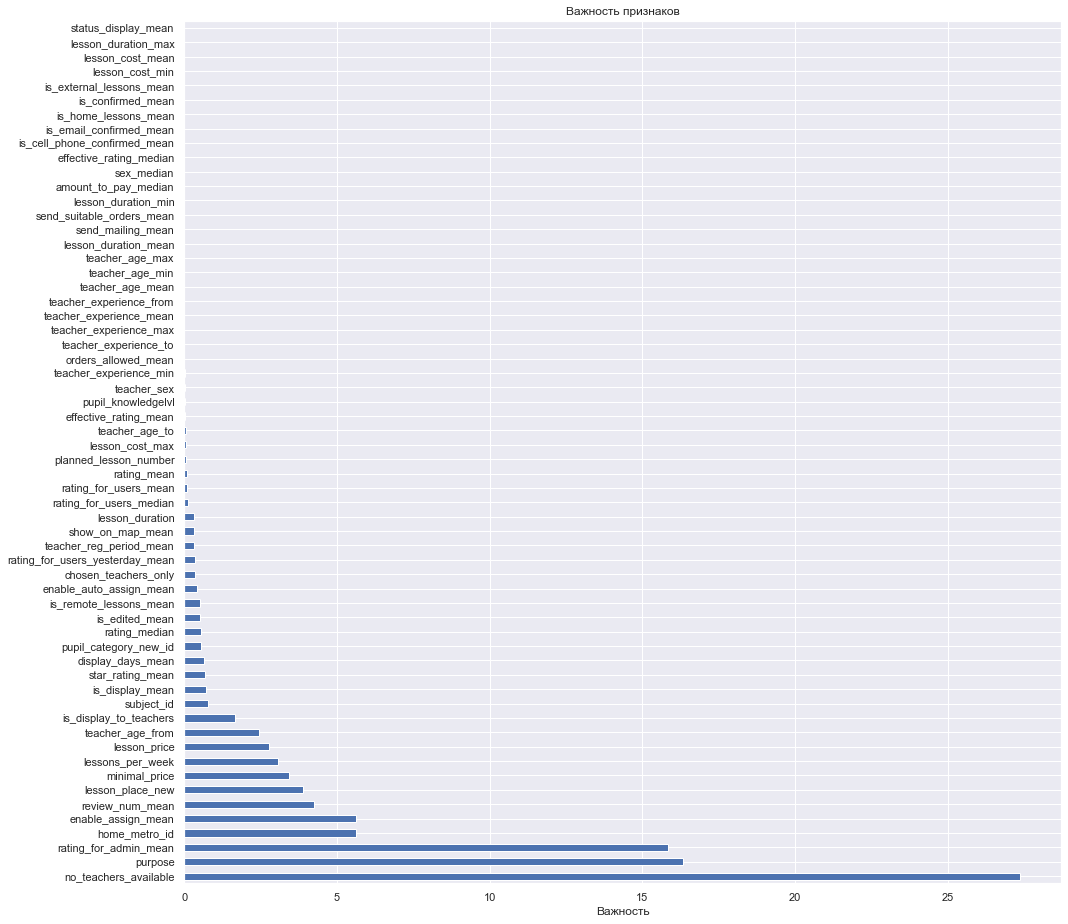

In [108]:
# извлечем из модели важность признаков и отсортируем признаки по доле важности
feature_importances = pd.Series(model_catboost_downsample.feature_importances_, X_test_grad.columns).sort_values(ascending=False)

# построим график важности признаков
fig, ax = plt.subplots(figsize=(15, 13))
feature_importances.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_xlabel('Важность')
fig.tight_layout()

Наиболее значимыми признаками оказались:
- признак наличия доступных репетиторов для заявки
- текстовый признаки с целью обучения ученика
- рейтинг репетитора для администрации сайта

При обучении модели мы попробовали отсеять наимение значимые признаки, такие как status_display_mean и lesson_duration_max, но это вызвало лишь небольшое ухудшение метрик.

## Результаты финальной модели

In [130]:
y_test.value_counts()

0    134139
1     73390
Name: target, dtype: int64


True Positives(TP) =  122282

True Negatives(TN) =  18293

False Positives(FP) =  11857

False Negatives(FN) =  55097


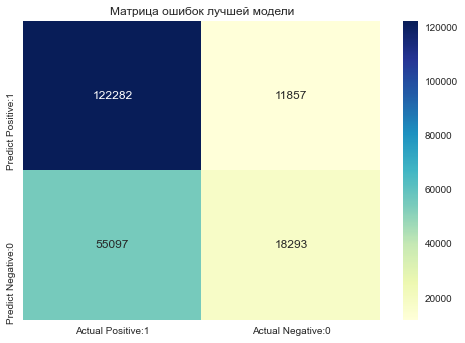

In [129]:
# найдем матрицу ошибок лучшей модели
preds_test = model_catboost_downsample.predict(X_test_grad)
cm = confusion_matrix(y_test, preds_test)

print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# визуализируем матрицу ошибок лучшей модели
cm_matrix = pd.DataFrame(
    data=cm, 
    columns=['Actual Positive:1', 'Actual Negative:0'], 
    index=['Predict Positive:1', 'Predict Negative:0']
)

sns.heatmap(
    cm_matrix, 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu'
);
plt.title('Матрица ошибок лучшей модели')
plt.show()

In [121]:
get_metrics(model_catboost_downsample, X_test_grad, y_test)

best_params: {'iterations': 100, 'verbose': 100, 'eval_metric': 'F1', 'boosting_type': 'Plain', 'random_state': 45, 'early_stopping_rounds': 25, 'cat_features': ['subject_id', 'lesson_duration', 'home_metro_id', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'teacher_sex', 'lesson_place_new', 'pupil_knowledgelvl', 'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers', 'lesson_duration_min', 'lesson_duration_max', 'rating_median', 'sex_median', 'amount_to_pay_median'], 'text_features': ['purpose'], 'learning_rate': 0.06}


,ROC-AUC,Precision,Recall,F1-score
test,0.699409,0.606733,0.249257,0.353351


              precision    recall  f1-score   support

           0       0.69      0.91      0.79    134139
           1       0.61      0.25      0.35     73390

    accuracy                           0.68    207529
   macro avg       0.65      0.58      0.57    207529
weighted avg       0.66      0.68      0.63    207529



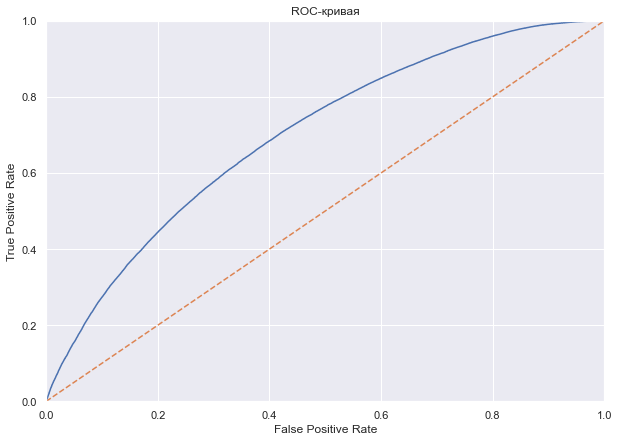

In [110]:
# построим ROC-кривую
proba_preds_test = model_catboost_downsample.predict_proba(X_test_grad)
fpr, tpr, thresholds = roc_curve(y_test, proba_preds_test[:, 1])
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)

# для сравнения пунктиром отобразим на графике ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# Выводы

1. В самом начале проекта мы успешно загрузили данные и провели их легкую разведку. В данных было множество малополезных признаков и признаков из будущего. Некоторые столбцы возможно были дублированы при выгрузке из БД. В колонках присутствовали множественные пропуски, а также было небольшое количество полных дубликатов строк.

2. Мы удалили признаки из будущего и бесполезные признаки, дав краткий комментарий по каждому. Также мы отсеяли репетиторов, которых не подходят к нашим заявкам и информация о которых будет лишней. 

3. Мы удалили столбцы-дубликаты: они, вероятно, образовались при выгрузке данных из БД. Полные дубликаты строк тоже были убраны из данных.
Мы убрали небольшую долю выбросов в датасете репетиторов. Но не стали удалять выбросы в данных заявок. Они могут говорить о нерелевантном заполнении заявки и о ее бесперпективности. Пустые значения и пропуски тоже могут свидетельствовать о бесперспективности заявки.

4. Мы добавили даты заявок в датасет с подходящими репетиторами. Это помогло нам вычислить актуальные данные на момент подачи заявки: возраст и стаж репетитора, срок с момента регистрации и срок с последнего захода на сайт. Также мы объединили данные репетиторов и подходящих репетиторов. Затем агрегировали информацию о репетиторах для каждой заявки и добавили получившиеся признаки к заявкам.

5. Синтезировали целевой признак со следующей логикой: если хотя бы одна заявка из кластера дублей оплачена, помечаем как оплаченные все заявки кластера. Мы успешно разделили данные на выборки, проследив за тем, чтобы заявки из одного кластера не попали в разные выборки. Также мы удалили неактуальные более признаки.
   
6. Мы успешно обучили классификатор CatBoost на кросс-валидации, который показал неплохие результаты практически без подбора гиперпараметров. Модель имеет дальнейший потенциал улучшения.

**Итог:**

Мы создали первоначальное рабочее решение с большим потенциалом к улучшению. В будущем мы: 
- синтезируем новые признаки, например:
    - категориальные признаки по таргету
    - признаки соответствия репетиторов заявке
    - доля заполненных полей в заявке
- отсеем малополезные признаки при помощи корреляционного phik-анализа и анализа признаков обученной модели
- добавим модели новых гиперпараметров
- протестируем другие модели
- попробуем применить прочие методы обработки дисбаланса, например SMOTE
- добавим новых выводов
- проведем векторизацию текстов, используя плотные вектора